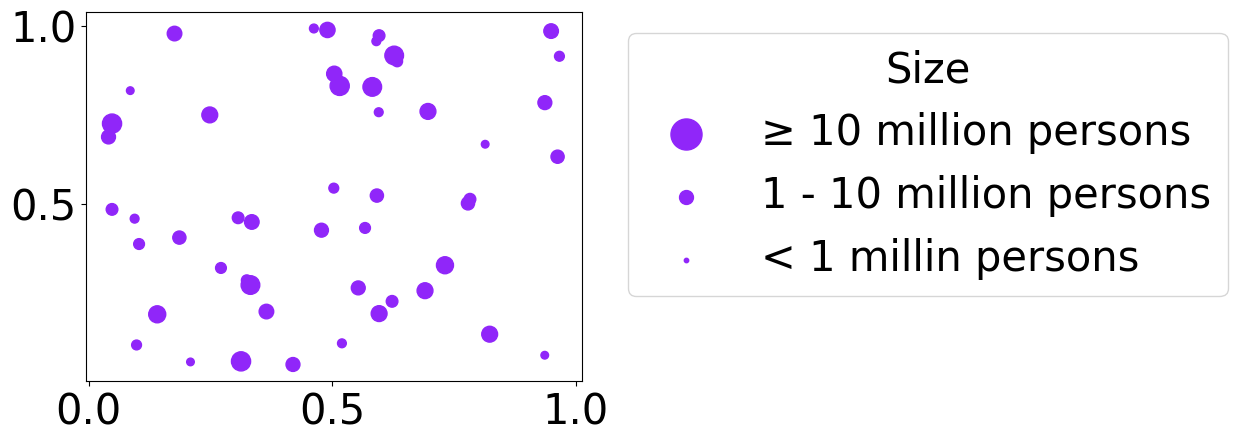

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# サンプルデータ
x = np.random.rand(50)
y = np.random.rand(50)
sizes = np.random.randint(1, 20, size=50) * 10  # 点のサイズ

# scatter plotの作成
color = '#9026f9'
plt.scatter(x, y, s=sizes, color=color, alpha=1)
plt.rcParams["font.size"] = 30

# 凡例の作成
handles = [
    plt.scatter([], [], s=500, color=color, alpha=1, label='≥ 10 million persons'),
    plt.scatter([], [], s=100, color=color, alpha=1, label='1 - 10 million persons'),
    plt.scatter([], [], s=10, color=color, alpha=1, label='< 1 millin persons')
]

# 凡例をプロット
plt.legend(handles=handles, title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')


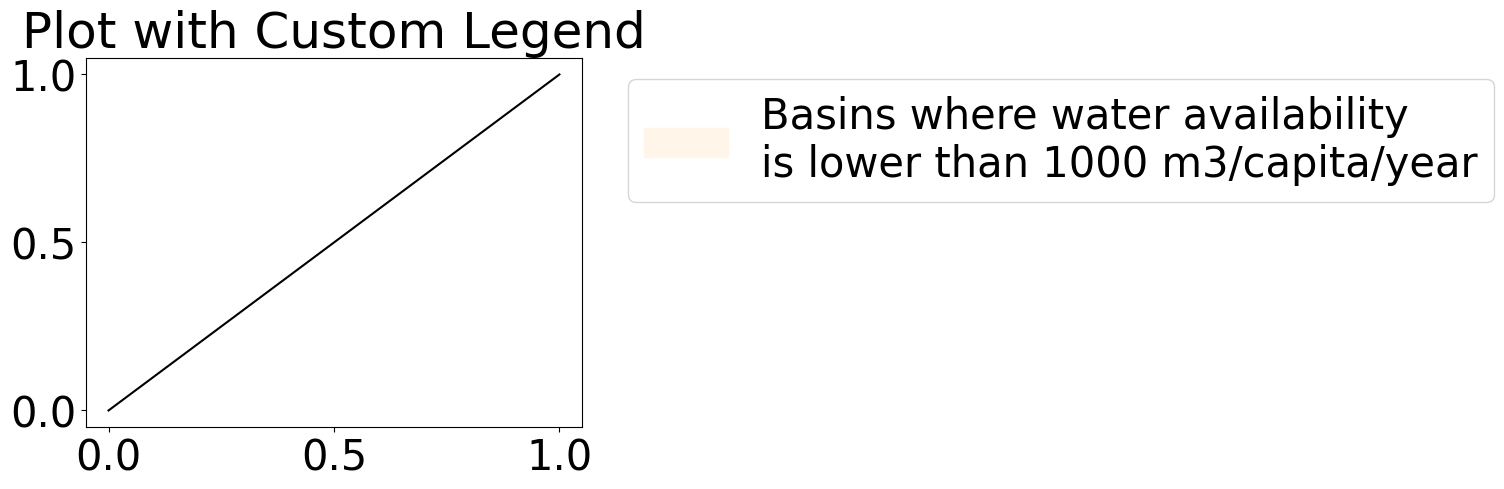

In [5]:
import matplotlib.patches as mpatches
custom_patch = mpatches.Patch(color='#fff5e9', label='Basins where water availability\nis lower than 1000 m3/capita/year')

# プロットの作成
fig, ax = plt.subplots()

# カスタム凡例の追加
#ax.legend(handles=[custom_patch])
ax.legend(handles=[custom_patch], bbox_to_anchor=(1.05, 1), loc='upper left')

# プロットの設定
ax.plot([0, 1], [0, 1], color='k', label='Example Line')
ax.set_title('Plot with Custom Legend')

plt.show()

81604


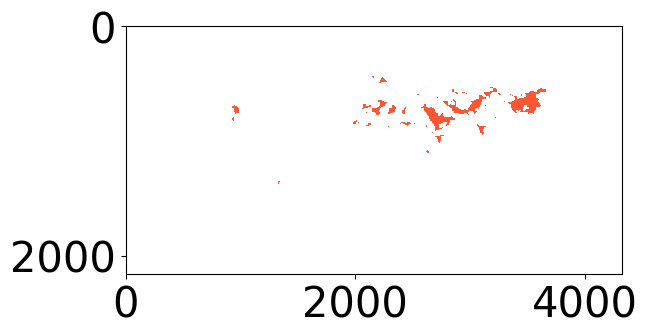

In [7]:
from matplotlib.colors import LinearSegmentedColormap

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
pop_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
pop = np.fromfile(pop_path, dtype='float32').reshape(2160, 4320)
riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)
rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
rivara = np.fromfile(rivara_path, dtype='float32').reshape(2160, 4320)
lndmsk_path = f'{h08dir}/global_city/dat/lnd_msk_/lndmsk.CAMA.gl5'
lndmsk = np.fromfile(lndmsk_path, dtype='float32').reshape(2160, 4320)

uids = np.unique(rivnum)
print(len(uids))

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent
    
loadpath = f'{h08dir}/wsi/dat/MPCY/world_basin_mpcy.npy'
world = np.load(loadpath)
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(-180, 180, -90, 90)
lndmsk_cropped = lndmsk[upperindex:lowerindex, leftindex:rightindex]
region = world[upperindex:lowerindex, leftindex:rightindex]
region_lnd = np.ma.masked_where(lndmsk_cropped==0, region)
#region_lnd[region_lnd==0] = -1
region_masked = np.ma.masked_where(region_lnd==0, region_lnd)
light_basin = np.ma.masked_where(region_masked>=1700, region_masked)
heavy_basin = np.ma.masked_where(region_masked>=1000, region_masked)
color = '#ff5733'  # オレンジ色 (好きな色を指定)
cmap = LinearSegmentedColormap.from_list('single_color_cmap', [color, color], N=256)
plt.imshow(light_basin, cmap=cmap)
plt.show()

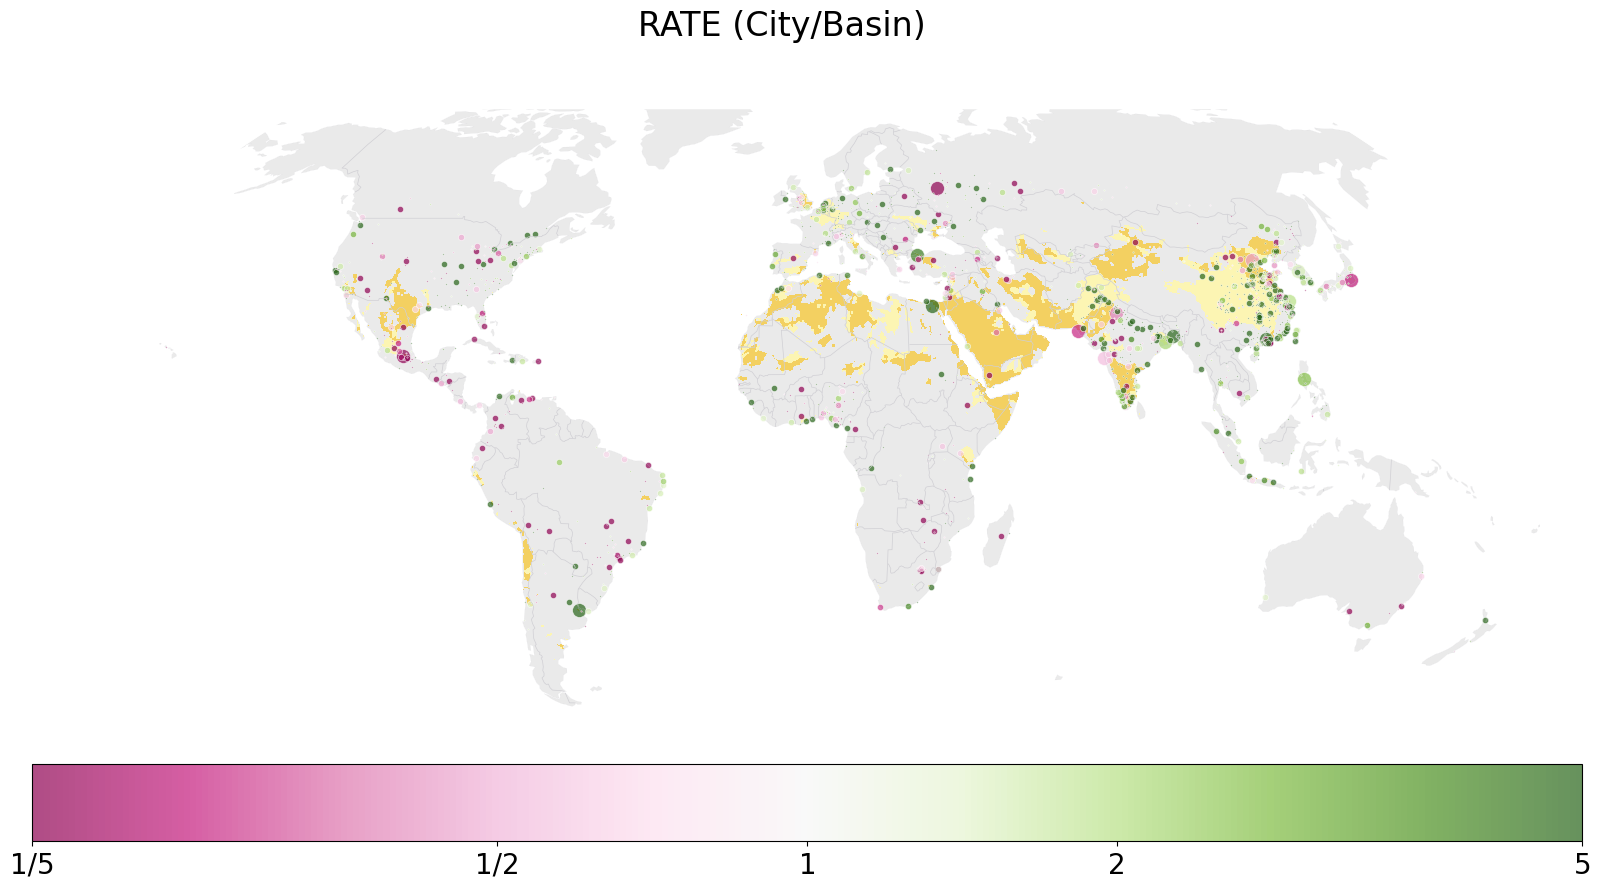

In [46]:
# city_num=946 Siping has no water availability bug

import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
city_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat_100km_abandon_revised.npy'
basin_path = f'{h08dir}/wsi/dat/cmy/cmy_basinlonlat.npy'
city_list = np.load(city_path)
basin_list = np.load(basin_path)

mpcy_path = f"{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt"
with open(mpcy_path, 'r') as files:
    text = files.readlines()

population = []
mpcy_lst = []

### calc job
for ind in range(1, 1861):
    line = text[ind]
    parts = line.split('|')
    parts = [item.strip() for item in parts]
    
    city_num = int(parts[0])
    flag = parts[1]
    
    if flag == 'NoMASK':
        continue
    else:
        rate = parts[2]
        wup = float(parts[3])
        wup_unit = wup / 1e3
        dwn = float(parts[4])
        dwn_unit = dwn
        if parts[12]:
            ava_int = float(parts[12])
            ava_unit = ava_int / 1e9
        else:
            ava_int = float(parts[5])
            ava_unit = ava_int / 1e9
        if parts[13]:
            mpcy_int = float(parts[13])
        else:
            mpcy_int = float(parts[6])
            
        # check error
        if mpcy_int <= 0:
            print(ind, mpcy_int)

    mpcy_lst.append(mpcy_int)
    population.append(dwn_unit)
    
pop_array = np.array(population)

RATE = []
DIFF = []
for i, j, k in zip(city_list, basin_list, mpcy_lst):
    rate = float(k) / float(j[3])
    diff = float(k) - float(j[3])
    
    RATE.append([i[0], i[1], i[2], rate])
    DIFF.append([i[0], i[1], i[2], diff])

# diff
diff_array = np.array(DIFF, dtype=object)
for i in range(4):
    diff_array[:, i] = diff_array[:, i].astype(float)
percentile = 50
max_abs_diff = np.percentile(np.abs(diff_array[:, 3]), percentile)
diff_tmp = diff_array[:, 3] / max_abs_diff
diff_array[:, 3] = diff_tmp

# rate
rate_array = np.array(RATE, dtype=object)
for i in range(4):
    rate_array[:, i] = rate_array[:, i].astype(float)
for i in range(len(rate_array)):
    rate_tmp[i] = np.where(rate_array[i, 3] > 1, rate_array[i, 3], -1 / rate_array[i, 3])
rate_array[:, 3] = rate_tmp

def plot_world(array, norm, cmap, extent):
    plt.rcParams["font.size"] = 20
    projection = ccrs.Robinson(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20, 10), edgecolor='none', subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=crs)
    
    for i, pop in zip(array, pop_array):
        if pop >= 1e7:
            size = 100
        elif 1e6 <= pop and pop < 1e7:
            size = 20
        else:
            size = 1
        ax.scatter(i[1], i[2], c=i[3], s=size, cmap=cmap, norm=norm,
                   transform=ccrs.PlateCarree(), alpha=0.7, edgecolor='white', linewidth=0.5)
        
    light_cmap = mcolors.ListedColormap(['#fcf5b3'])
    ax.imshow(light_basin, transform=ccrs.PlateCarree(), cmap=light_cmap)
    heavy_cmap = mcolors.ListedColormap(['#f3d061'])
    ax.imshow(heavy_basin, transform=ccrs.PlateCarree(), cmap=heavy_cmap)
        
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1, edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='#d0cfd4')
    ax.spines['geo'].set_visible(False)
    
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks([-5, -2, 0, 2, 5])  # Ticksの設定
    cbar.set_ticklabels(['1/5', '1/2', '1', '2', '5'])  # Tick labelsの設定
    fig.suptitle('RATE (City/Basin)')
    plt.show()

### plot job
cmap_base = plt.get_cmap('PiYG')
colors = cmap_base(np.linspace(0, 0.9, cmap_base.N))
white_to_gray = np.linspace(1, 0.7, cmap_base.N // 2)
for i in range(cmap_base.N // 2, cmap_base.N):
    colors[i] = [white_to_gray[i - cmap_base.N // 2]] * 3 + [1]
cmap_custom = LinearSegmentedColormap.from_list('PiYG_custom', colors)

extent = [-180, 180, -60, 75]
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5)
plot_world(rate_array, norm, cmap_base, extent)

[1.0 139.69171 35.6895 1.0]


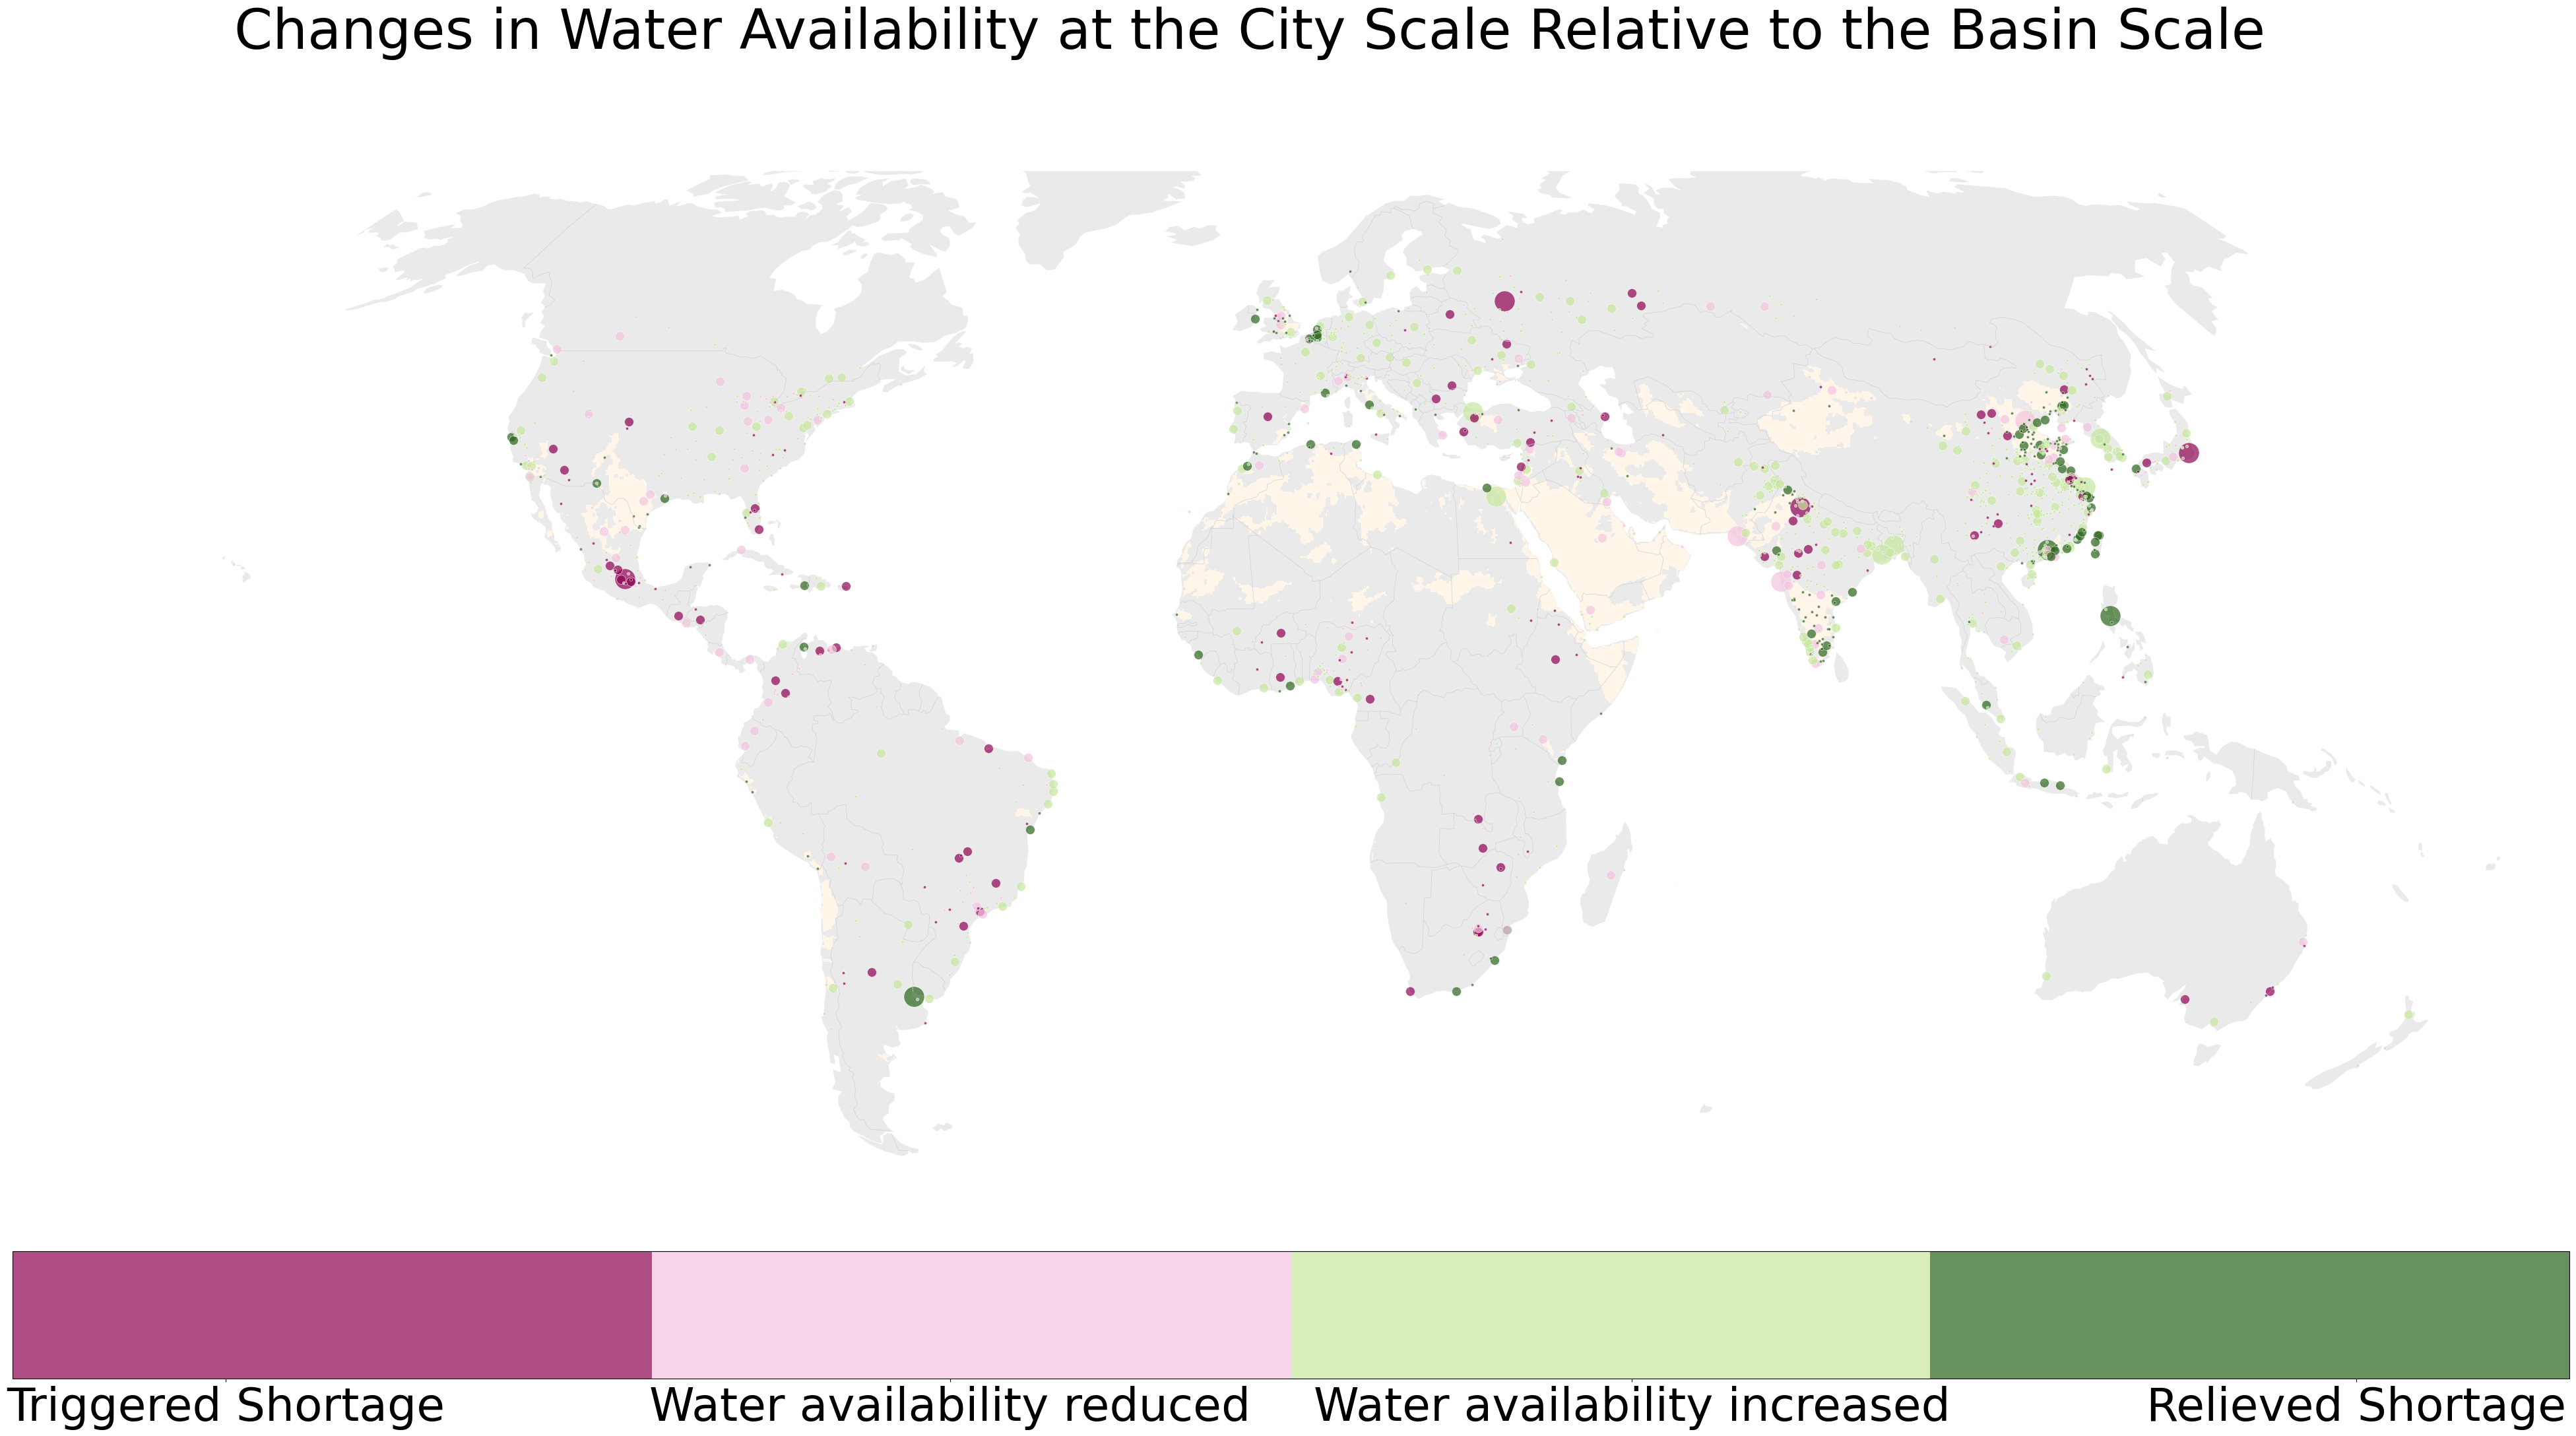

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
city_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat_100km_abandon_revised.npy'
basin_path = f'{h08dir}/wsi/dat/cmy/cmy_basinlonlat.npy'
city_list = np.load(city_path)
basin_list = np.load(basin_path)

mpcy_path = f"{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt"
with open(mpcy_path, 'r') as files:
    text = files.readlines()

population = []
mpcy_lst = []

for ind in range(1, 1861):
    line = text[ind]
    parts = line.split('|')
    parts = [item.strip() for item in parts]
    
    city_num = int(parts[0])
    flag = parts[1]
    
    if flag == 'NoMASK':
        continue
    else:
        rate = parts[2]
        wup = float(parts[3])
        wup_unit = wup / 1e3
        dwn = float(parts[4])
        dwn_unit = dwn
        if parts[12]:
            ava_int = float(parts[12])
            ava_unit = ava_int / 1e9
        else:
            ava_int = float(parts[5])
            ava_unit = ava_int / 1e9
        if parts[13]:
            mpcy_int = float(parts[13])
        else:
            mpcy_int = float(parts[6])
            
        # check error
        if mpcy_int <= 0:
            print(ind, mpcy_int)

    mpcy_lst.append(mpcy_int)
    population.append(dwn_unit)

### j > 1000
# j > k and k > 1000
# j > k and k < 1000
# k > j
### j < 1000
# j > k and k < 1000
# k > j and k < 1000
# k > j and k > 1000

### red
# j > k and k < 1000 and j > 1000 * stress switch
# j > k and k < 1000 and j < 1000 * worse stress
# j > k and k > 1000 and j > 1000 * slight change
### blue 
# k > j and k > 1000 and j > 1000 * better stress
# k > j and k < 1000 and j < 1000 * slight change
# k > j and k > 1000 and j < 1000 * stress switch

stress_thres = 1000
FLAG = []

for i, j, k in zip(city_list, basin_list, mpcy_lst):
    l = j[3]
    # l is basin mpcy and k is city mpcy
    if l > k:
        if   k < stress_thres and l > stress_thres:
            flag = 1
        elif k < stress_thres and l < stress_thres:
            flag = 2
        elif k > stress_thres and l > stress_thres:
            flag = 2
    elif k > l:
        if   k > stress_thres and l > stress_thres:
            flag = 3
        elif k < stress_thres and l < stress_thres:
            flag = 3
        elif k > stress_thres and l < stress_thres:
            flag = 4
        
    FLAG.append([i[0], i[1], i[2], flag])

# string to float
flag_array = np.array(FLAG, dtype=object)
for i in range(len(flag_array)):
    flag_array[i] = flag_array[i].astype(float)
print(flag_array[0])

def plot_world(array, norm, cmap, extent):
    plt.rcParams["font.size"] = 50
    projection = ccrs.Robinson(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50, 25), edgecolor='none', subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=crs)

    # scatter plot
    for i, pop in zip(array, pop_array):
        if pop >= 1e7:
            size = 500
        elif 1e6 <= pop and pop < 1e7:
            size = 100
        else:
            size = 10
        ax.scatter(i[1], i[2], c=i[3], s=size, cmap=cmap, norm=norm,
                   transform=ccrs.PlateCarree(), alpha=0.7, edgecolor='white', linewidth=0.5)

    # background plot
    #light_cmap = mcolors.ListedColormap(['#fcf5b3'])
    #ax.imshow(light_basin, transform=ccrs.PlateCarree(), cmap=light_cmap)
    heavy_cmap = mcolors.ListedColormap(['#f3d061'])
    heavy_cmap = mcolors.ListedColormap(['#fff5e9'])
    ax.imshow(heavy_basin, transform=ccrs.PlateCarree(), cmap=heavy_cmap)
        
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1, edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='#d0cfd4')
    ax.spines['geo'].set_visible(False)

    # colorbar plot
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks([1.25, 2.1, 2.9, 3.75])  # Ticksの設定
    cbar.set_ticklabels(['Triggered Shortage', 'Water availability reduced', 'Water availability increased', 'Relieved Shortage'])  # Tick labelsの設定
    fig.suptitle('Changes in Water Availability at the City Scale Relative to the Basin Scale')
    plt.show()

cmap_base = plt.get_cmap('PiYG')
colors = cmap_base(np.linspace(0, 1, 4))
cmap_discrete = mcolors.ListedColormap(colors, name='PiYG_discrete')

extent = [-180, 180, -60, 75]
norm = mcolors.TwoSlopeNorm(vcenter=2.5, vmin=1, vmax=4)
plot_world(flag_array, norm, cmap_discrete, extent)

[1.0 139.69171 35.6895 1.0]


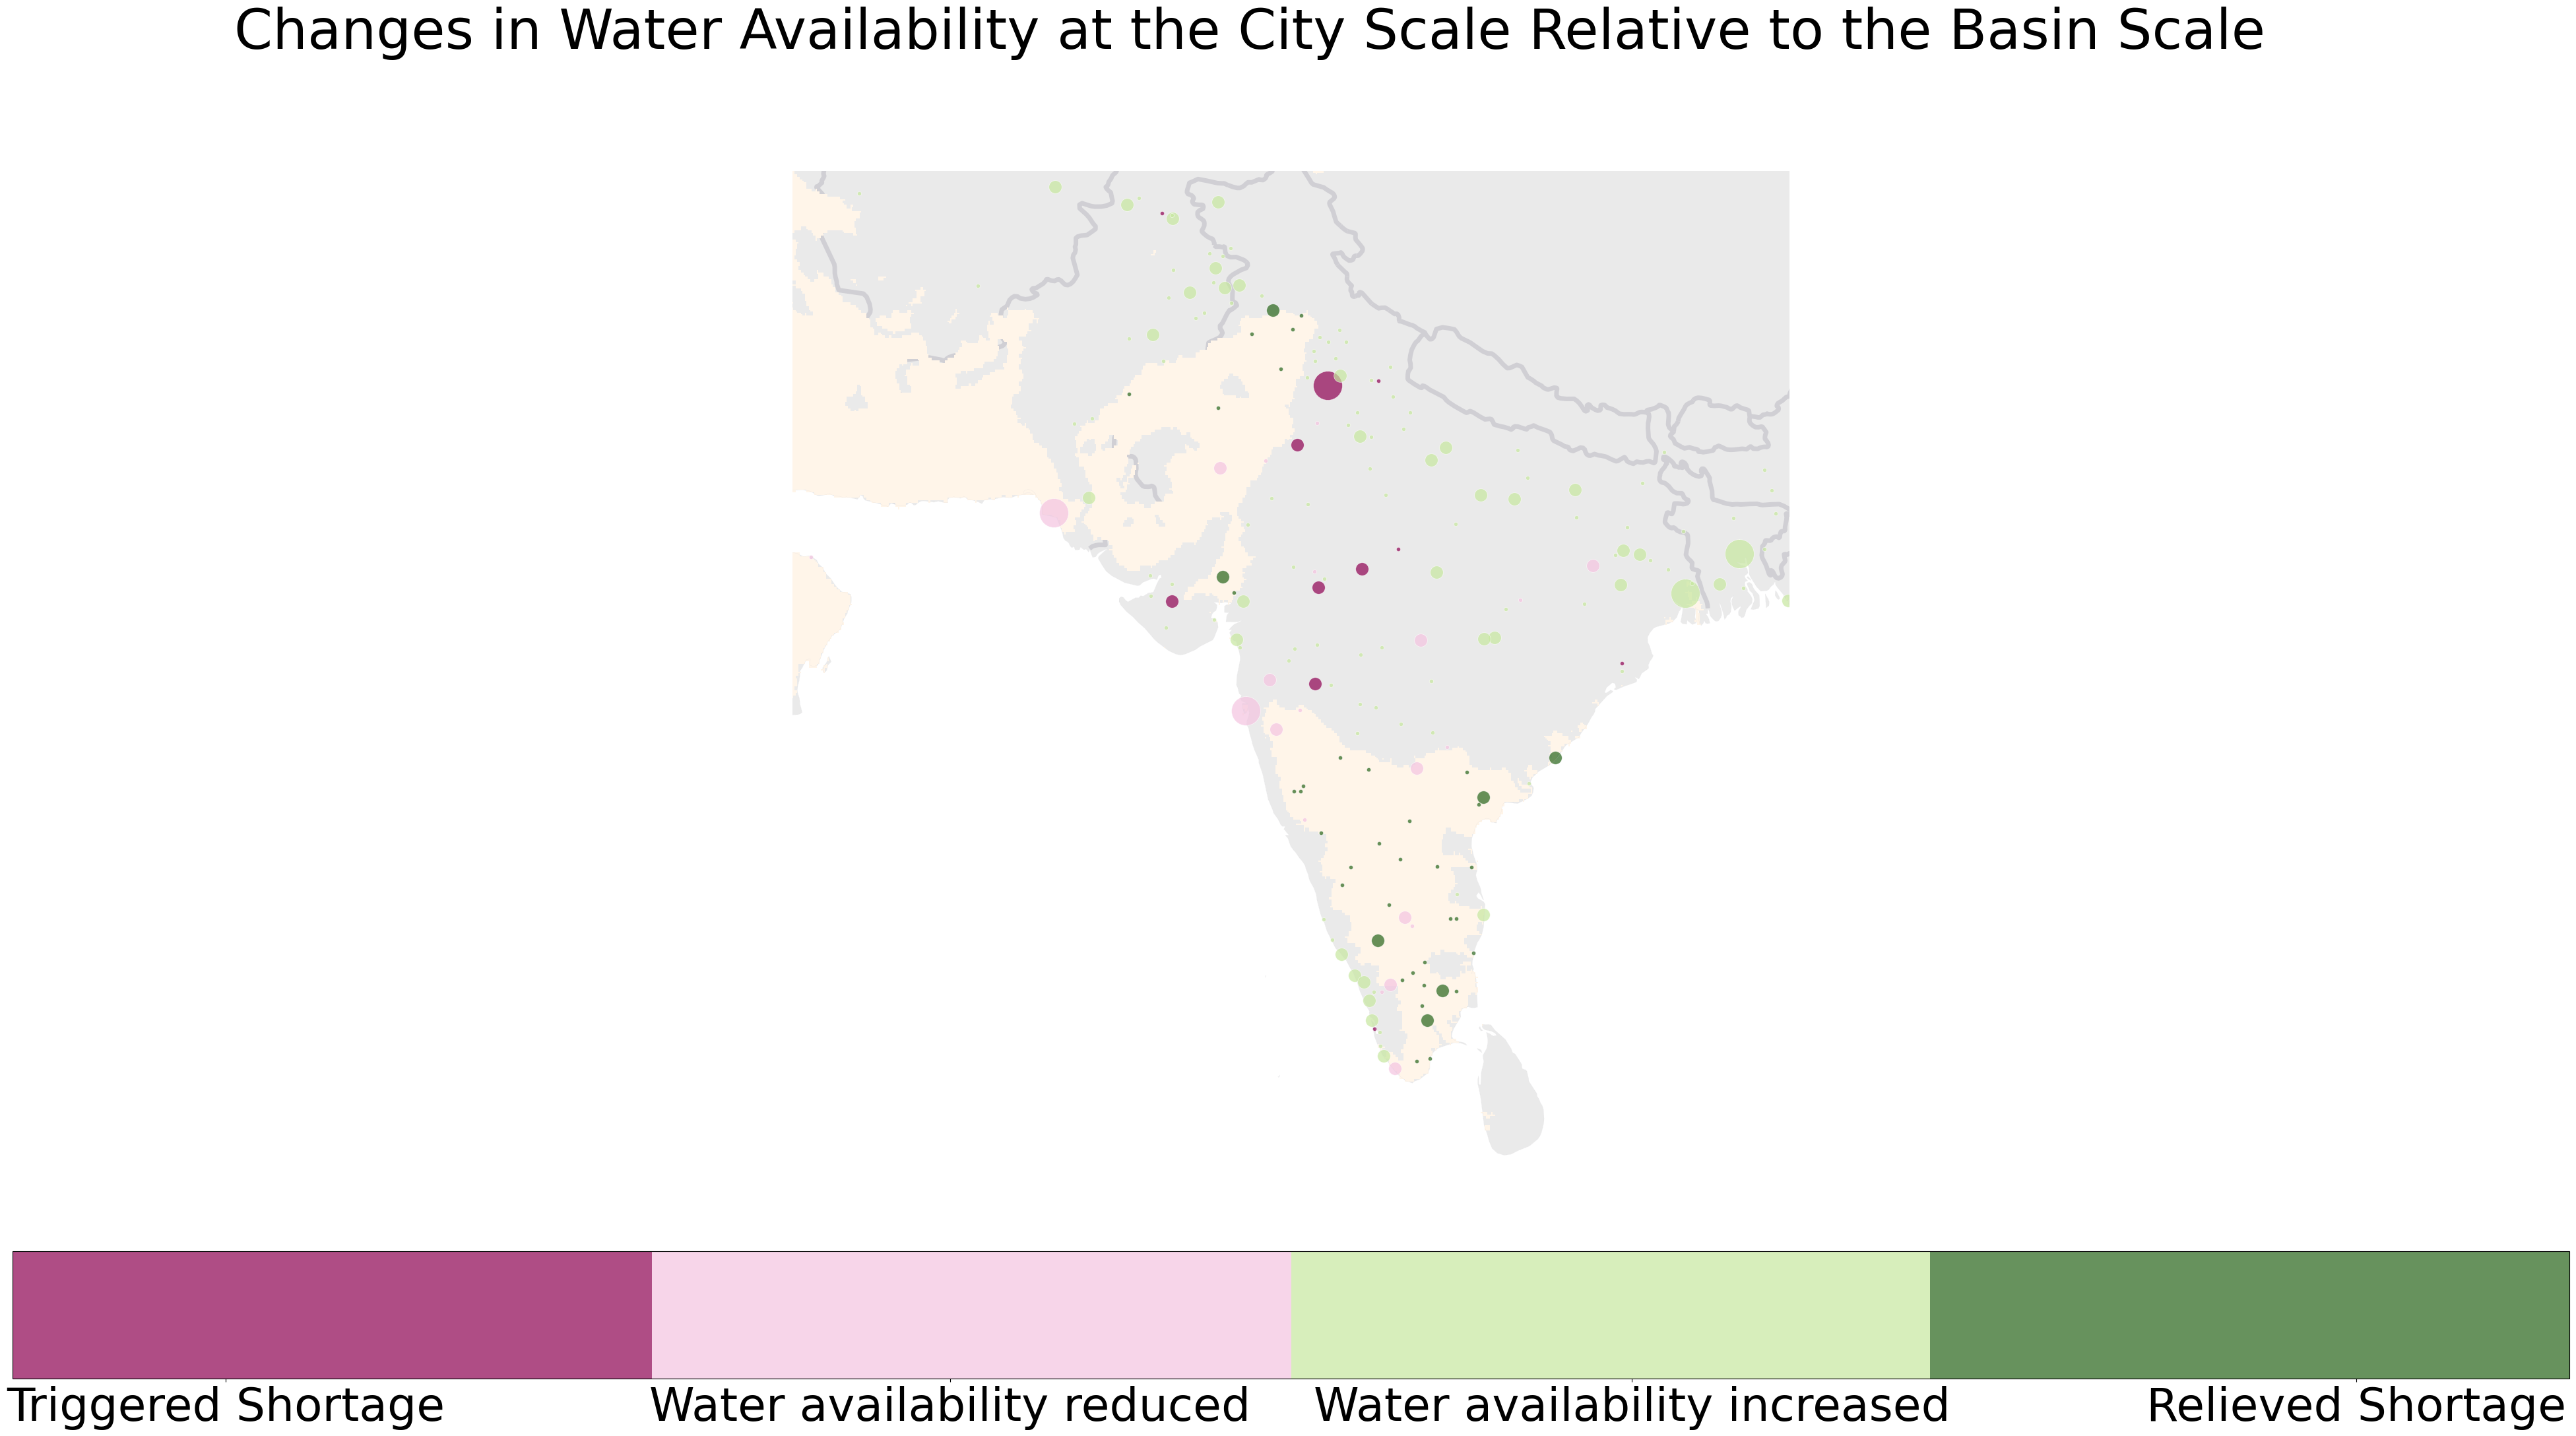

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
city_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat_100km_abandon_revised.npy'
basin_path = f'{h08dir}/wsi/dat/cmy/cmy_basinlonlat.npy'
city_list = np.load(city_path)
basin_list = np.load(basin_path)

mpcy_path = f"{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt"
with open(mpcy_path, 'r') as files:
    text = files.readlines()

population = []
mpcy_lst = []

for ind in range(1, 1861):
    line = text[ind]
    parts = line.split('|')
    parts = [item.strip() for item in parts]
    
    city_num = int(parts[0])
    flag = parts[1]
    
    if flag == 'NoMASK':
        continue
    else:
        rate = parts[2]
        wup = float(parts[3])
        wup_unit = wup / 1e3
        dwn = float(parts[4])
        dwn_unit = dwn
        if parts[12]:
            ava_int = float(parts[12])
            ava_unit = ava_int / 1e9
        else:
            ava_int = float(parts[5])
            ava_unit = ava_int / 1e9
        if parts[13]:
            mpcy_int = float(parts[13])
        else:
            mpcy_int = float(parts[6])
            
        # check error
        if mpcy_int <= 0:
            print(ind, mpcy_int)

    mpcy_lst.append(mpcy_int)
    population.append(dwn_unit)

### j > 1000
# j > k and k > 1000
# j > k and k < 1000
# k > j
### j < 1000
# j > k and k < 1000
# k > j and k < 1000
# k > j and k > 1000

### red
# j > k and k < 1000 and j > 1000 * stress switch
# j > k and k < 1000 and j < 1000 * worse stress
# j > k and k > 1000 and j > 1000 * slight change
### blue 
# k > j and k > 1000 and j > 1000 * better stress
# k > j and k < 1000 and j < 1000 * slight change
# k > j and k > 1000 and j < 1000 * stress switch

stress_thres = 1000
FLAG = []

for i, j, k in zip(city_list, basin_list, mpcy_lst):
    l = j[3]
    # l is basin mpcy and k is city mpcy
    if l > k:
        if   k < stress_thres and l > stress_thres:
            flag = 1
        elif k < stress_thres and l < stress_thres:
            flag = 2
        elif k > stress_thres and l > stress_thres:
            flag = 2
    elif k > l:
        if   k > stress_thres and l > stress_thres:
            flag = 3
        elif k < stress_thres and l < stress_thres:
            flag = 3
        elif k > stress_thres and l < stress_thres:
            flag = 4
        
    FLAG.append([i[0], i[1], i[2], flag])

# string to float
flag_array = np.array(FLAG, dtype=object)
for i in range(len(flag_array)):
    flag_array[i] = flag_array[i].astype(float)
print(flag_array[0])

def plot_world(array, norm, cmap, extent):
    plt.rcParams["font.size"] = 50
    projection = ccrs.Robinson(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50, 25), edgecolor='none', subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=crs)

    # scatter plot
    for i, pop in zip(array, pop_array):
        if pop >= 1e7:
            size = 1000
        elif 1e6 <= pop and pop < 1e7:
            size = 200
        else:
            size = 20
        ax.scatter(i[1], i[2], c=i[3], s=size, cmap=cmap, norm=norm,
                   transform=ccrs.PlateCarree(), alpha=0.7, edgecolor='white', linewidth=0.5, zorder=1)

    # background plot
    #light_cmap = mcolors.ListedColormap(['#fcf5b3'])
    #ax.imshow(light_basin, transform=ccrs.PlateCarree(), cmap=light_cmap)
    heavy_cmap = mcolors.ListedColormap(['#f3d061'])
    heavy_cmap = mcolors.ListedColormap(['#fff5e9'])
    ax.imshow(heavy_basin, transform=ccrs.PlateCarree(), cmap=heavy_cmap, zorder=0)
        
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1, edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=5, edgecolor='#d0cfd4', zorder=-1)
    ax.spines['geo'].set_visible(False)

    # colorbar plot
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks([1.25, 2.1, 2.9, 3.75])  # Ticksの設定
    cbar.set_ticklabels(['Triggered Shortage', 'Water availability reduced', 'Water availability increased', 'Relieved Shortage'])  # Tick labelsの設定
    fig.suptitle('Changes in Water Availability at the City Scale Relative to the Basin Scale')
    plt.show()

cmap_base = plt.get_cmap('PiYG')
colors = cmap_base(np.linspace(0, 1, 4))
cmap_discrete = mcolors.ListedColormap(colors, name='PiYG_discrete')

extent = [60, 90, 5, 35]
norm = mcolors.TwoSlopeNorm(vcenter=2.5, vmin=1, vmax=4)
plot_world(flag_array, norm, cmap_discrete, extent)

[1.0 139.69171 35.6895 1.0]


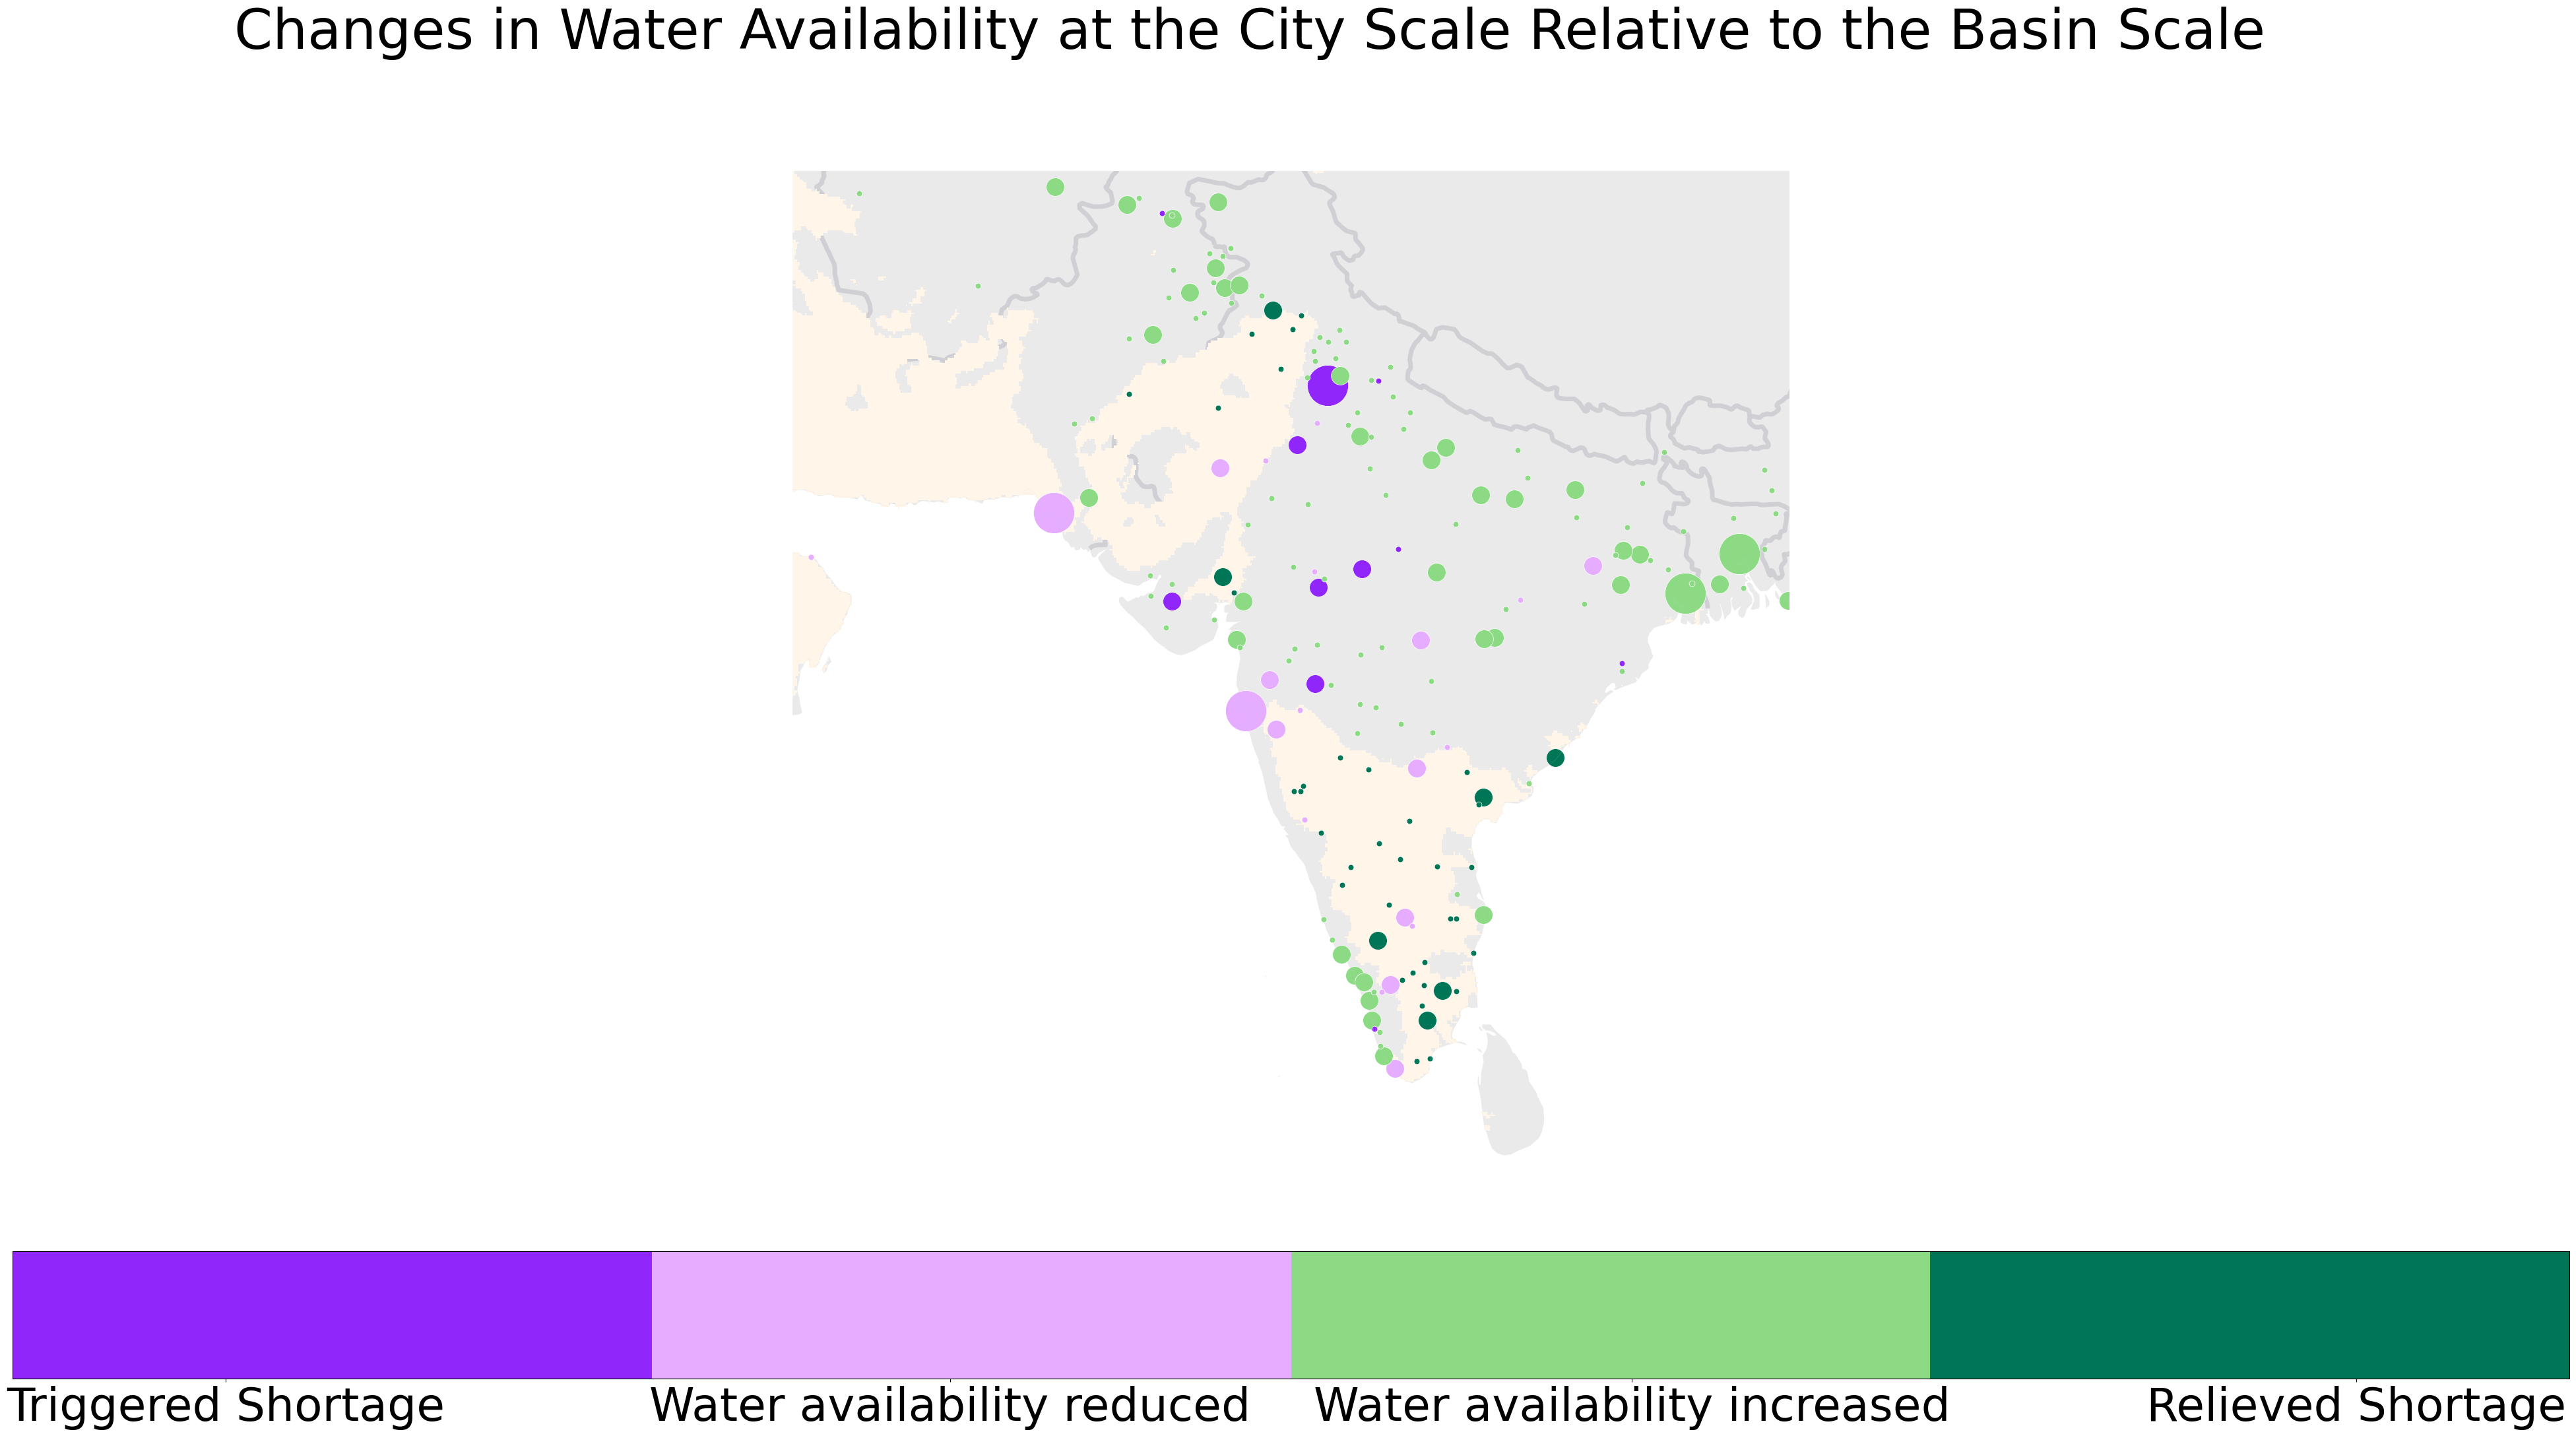

In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
city_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat_100km_abandon_revised.npy'
basin_path = f'{h08dir}/wsi/dat/cmy/cmy_basinlonlat.npy'
city_list = np.load(city_path)
basin_list = np.load(basin_path)

mpcy_path = f"{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt"
with open(mpcy_path, 'r') as files:
    text = files.readlines()

population = []
mpcy_lst = []

for ind in range(1, 1861):
    line = text[ind]
    parts = line.split('|')
    parts = [item.strip() for item in parts]
    
    city_num = int(parts[0])
    flag = parts[1]
    
    if flag == 'NoMASK':
        continue
    else:
        rate = parts[2]
        wup = float(parts[3])
        wup_unit = wup / 1e3
        dwn = float(parts[4])
        dwn_unit = dwn
        if parts[12]:
            ava_int = float(parts[12])
            ava_unit = ava_int / 1e9
        else:
            ava_int = float(parts[5])
            ava_unit = ava_int / 1e9
        if parts[13]:
            mpcy_int = float(parts[13])
        else:
            mpcy_int = float(parts[6])
            
        # check error
        if mpcy_int <= 0:
            print(ind, mpcy_int)

    mpcy_lst.append(mpcy_int)
    population.append(dwn_unit)

### j > 1000
# j > k and k > 1000
# j > k and k < 1000
# k > j
### j < 1000
# j > k and k < 1000
# k > j and k < 1000
# k > j and k > 1000

### red
# j > k and k < 1000 and j > 1000 * stress switch
# j > k and k < 1000 and j < 1000 * worse stress
# j > k and k > 1000 and j > 1000 * slight change
### blue 
# k > j and k > 1000 and j > 1000 * better stress
# k > j and k < 1000 and j < 1000 * slight change
# k > j and k > 1000 and j < 1000 * stress switch

stress_thres = 1000
FLAG = []

for i, j, k in zip(city_list, basin_list, mpcy_lst):
    l = j[3]
    # l is basin mpcy and k is city mpcy
    if l > k:
        if   k < stress_thres and l > stress_thres:
            flag = 1
        elif k < stress_thres and l < stress_thres:
            flag = 2
        elif k > stress_thres and l > stress_thres:
            flag = 2
    elif k > l:
        if   k > stress_thres and l > stress_thres:
            flag = 3
        elif k < stress_thres and l < stress_thres:
            flag = 3
        elif k > stress_thres and l < stress_thres:
            flag = 4
        
    FLAG.append([i[0], i[1], i[2], flag])

# string to float
flag_array = np.array(FLAG, dtype=object)
for i in range(len(flag_array)):
    flag_array[i] = flag_array[i].astype(float)
print(flag_array[0])

def plot_world(array, norm, cmap, extent):
    plt.rcParams["font.size"] = 50
    projection = ccrs.Robinson(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50, 25), edgecolor='none', subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=crs)

    # scatter plot
    for i, pop in zip(array, pop_array):
        if pop >= 1e7:
            size = 2000
        elif 1e6 <= pop and pop < 1e7:
            size = 400
        else:
            size = 40
        ax.scatter(i[1], i[2], c=i[3], s=size, cmap=cmap, norm=norm,
                   transform=ccrs.PlateCarree(), alpha=1, edgecolor='white', linewidth=0.5, zorder=1)

    # background plot
    #light_cmap = mcolors.ListedColormap(['#fcf5b3'])
    #ax.imshow(light_basin, transform=ccrs.PlateCarree(), cmap=light_cmap)
    heavy_cmap = mcolors.ListedColormap(['#f3d061'])
    heavy_cmap = mcolors.ListedColormap(['#fff5e9'])
    ax.imshow(heavy_basin, transform=ccrs.PlateCarree(), cmap=heavy_cmap, zorder=0)
        
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1, edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=5, edgecolor='#d0cfd4', zorder=-1)
    ax.spines['geo'].set_visible(False)

    # colorbar plot
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks([1.25, 2.1, 2.9, 3.75])  # Ticksの設定
    cbar.set_ticklabels(['Triggered Shortage', 'Water availability reduced', 'Water availability increased', 'Relieved Shortage'])  # Tick labelsの設定
    fig.suptitle('Changes in Water Availability at the City Scale Relative to the Basin Scale')
    plt.show()

cmap_discrete = mcolors.ListedColormap(['#9026f9', '#e6acff', '#8cdb84', '#007656'])

extent = [60, 90, 5, 35]
norm = mcolors.TwoSlopeNorm(vcenter=2.5, vmin=1, vmax=4)
plot_world(flag_array, norm, cmap_discrete, extent)

[1.0 139.69171 35.6895 1.0]


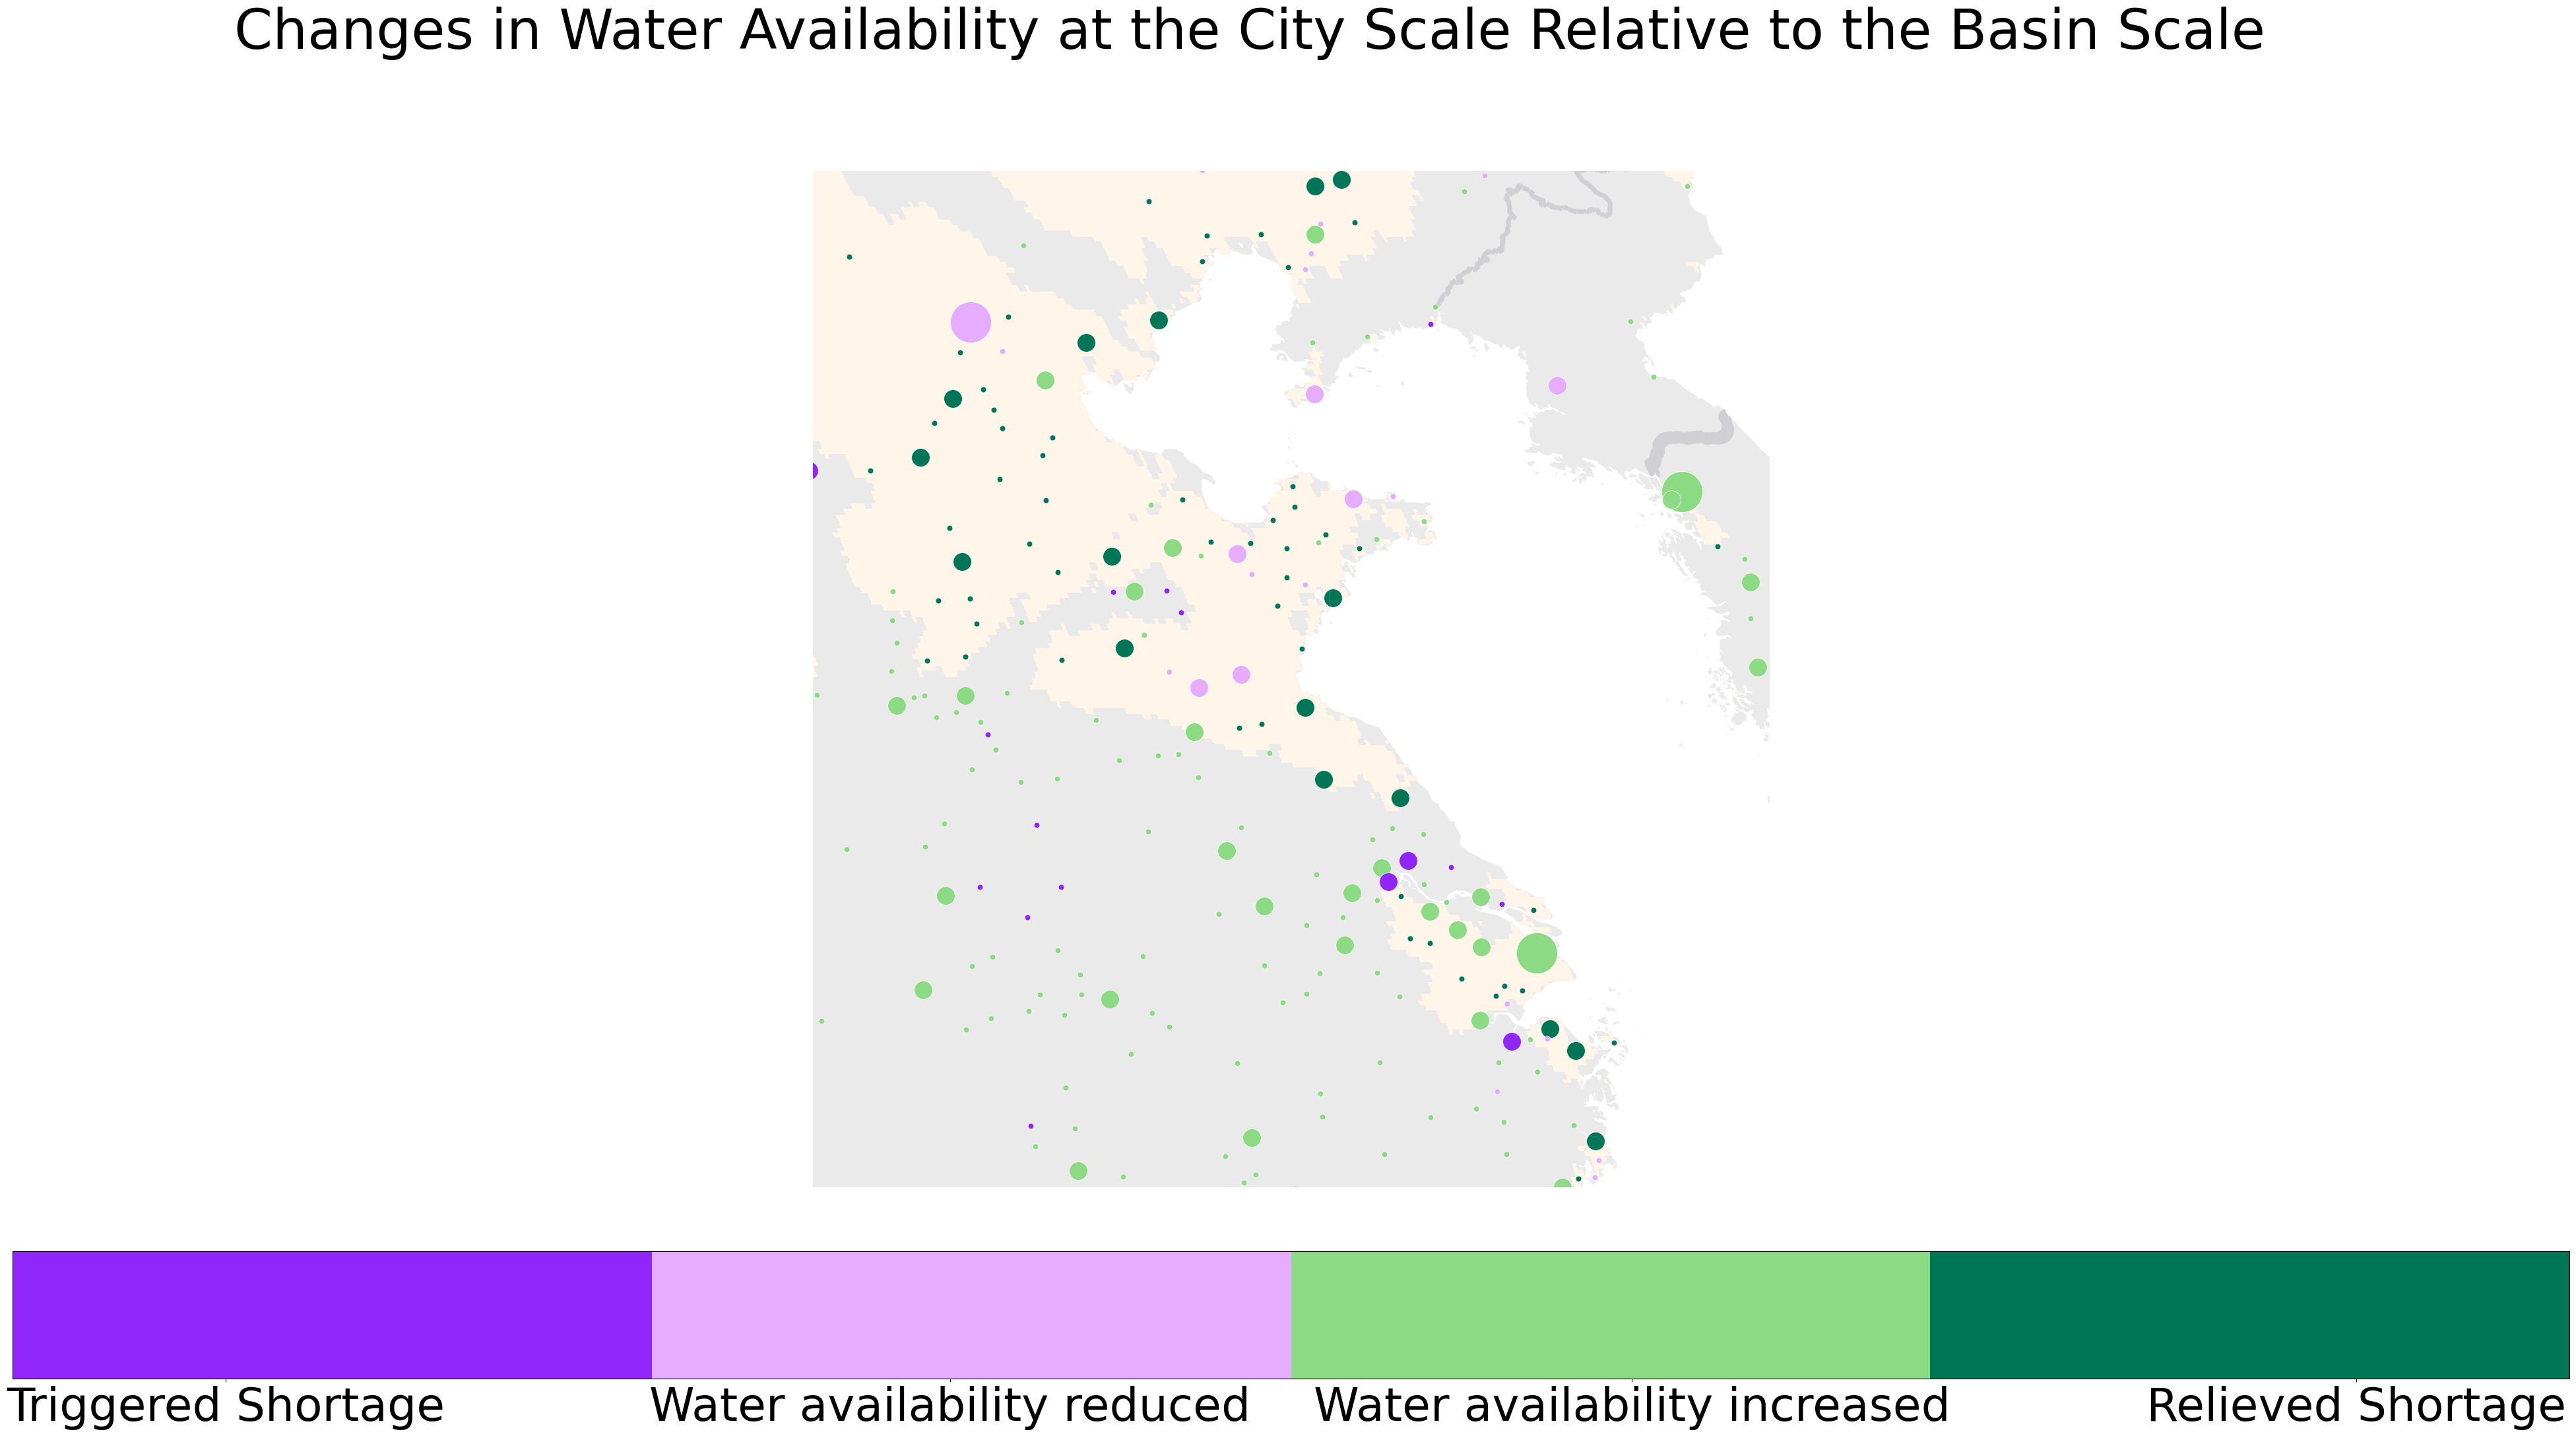

In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
city_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat_100km_abandon_revised.npy'
basin_path = f'{h08dir}/wsi/dat/cmy/cmy_basinlonlat.npy'
city_list = np.load(city_path)
basin_list = np.load(basin_path)

mpcy_path = f"{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt"
with open(mpcy_path, 'r') as files:
    text = files.readlines()

population = []
mpcy_lst = []

for ind in range(1, 1861):
    line = text[ind]
    parts = line.split('|')
    parts = [item.strip() for item in parts]
    
    city_num = int(parts[0])
    flag = parts[1]
    
    if flag == 'NoMASK':
        continue
    else:
        rate = parts[2]
        wup = float(parts[3])
        wup_unit = wup / 1e3
        dwn = float(parts[4])
        dwn_unit = dwn
        if parts[12]:
            ava_int = float(parts[12])
            ava_unit = ava_int / 1e9
        else:
            ava_int = float(parts[5])
            ava_unit = ava_int / 1e9
        if parts[13]:
            mpcy_int = float(parts[13])
        else:
            mpcy_int = float(parts[6])
            
        # check error
        if mpcy_int <= 0:
            print(ind, mpcy_int)

    mpcy_lst.append(mpcy_int)
    population.append(dwn_unit)

### j > 1000
# j > k and k > 1000
# j > k and k < 1000
# k > j
### j < 1000
# j > k and k < 1000
# k > j and k < 1000
# k > j and k > 1000

### red
# j > k and k < 1000 and j > 1000 * stress switch
# j > k and k < 1000 and j < 1000 * worse stress
# j > k and k > 1000 and j > 1000 * slight change
### blue 
# k > j and k > 1000 and j > 1000 * better stress
# k > j and k < 1000 and j < 1000 * slight change
# k > j and k > 1000 and j < 1000 * stress switch

stress_thres = 1000
FLAG = []

for i, j, k in zip(city_list, basin_list, mpcy_lst):
    l = j[3]
    # l is basin mpcy and k is city mpcy
    if l > k:
        if   k < stress_thres and l > stress_thres:
            flag = 1
        elif k < stress_thres and l < stress_thres:
            flag = 2
        elif k > stress_thres and l > stress_thres:
            flag = 2
    elif k > l:
        if   k > stress_thres and l > stress_thres:
            flag = 3
        elif k < stress_thres and l < stress_thres:
            flag = 3
        elif k > stress_thres and l < stress_thres:
            flag = 4
        
    FLAG.append([i[0], i[1], i[2], flag])

# string to float
flag_array = np.array(FLAG, dtype=object)
for i in range(len(flag_array)):
    flag_array[i] = flag_array[i].astype(float)
print(flag_array[0])

def plot_world(array, norm, cmap, extent):
    plt.rcParams["font.size"] = 50
    projection = ccrs.Robinson(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50, 25), edgecolor='none', subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=crs)

    # scatter plot
    for i, pop in zip(array, pop_array):
        if pop >= 1e7:
            size = 2000
        elif 1e6 <= pop and pop < 1e7:
            size = 400
        else:
            size = 40
        ax.scatter(i[1], i[2], c=i[3], s=size, cmap=cmap, norm=norm,
                   transform=ccrs.PlateCarree(), alpha=1, edgecolor='white', linewidth=0.5, zorder=1)

    # background plot
    #light_cmap = mcolors.ListedColormap(['#fcf5b3'])
    #ax.imshow(light_basin, transform=ccrs.PlateCarree(), cmap=light_cmap)
    heavy_cmap = mcolors.ListedColormap(['#f3d061'])
    heavy_cmap = mcolors.ListedColormap(['#fff5e9'])
    ax.imshow(heavy_basin, transform=ccrs.PlateCarree(), cmap=heavy_cmap, zorder=0)
        
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1, edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=5, edgecolor='#d0cfd4', zorder=-1)
    ax.spines['geo'].set_visible(False)

    # colorbar plot
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks([1.25, 2.1, 2.9, 3.75])  # Ticksの設定
    cbar.set_ticklabels(['Triggered Shortage', 'Water availability reduced', 'Water availability increased', 'Relieved Shortage'])  # Tick labelsの設定
    fig.suptitle('Changes in Water Availability at the City Scale Relative to the Basin Scale')
    plt.show()

cmap_base = plt.get_cmap('PiYG')
colors = cmap_base(np.linspace(0, 1, 4))
cmap_discrete = mcolors.ListedColormap(['#9026f9', '#e6acff', '#8cdb84', '#007656'])

extent = [115, 124, 28, 42]
norm = mcolors.TwoSlopeNorm(vcenter=2.5, vmin=1, vmax=4)
plot_world(flag_array, norm, cmap_discrete, extent)

[1.0 139.69171 35.6895 1.0]


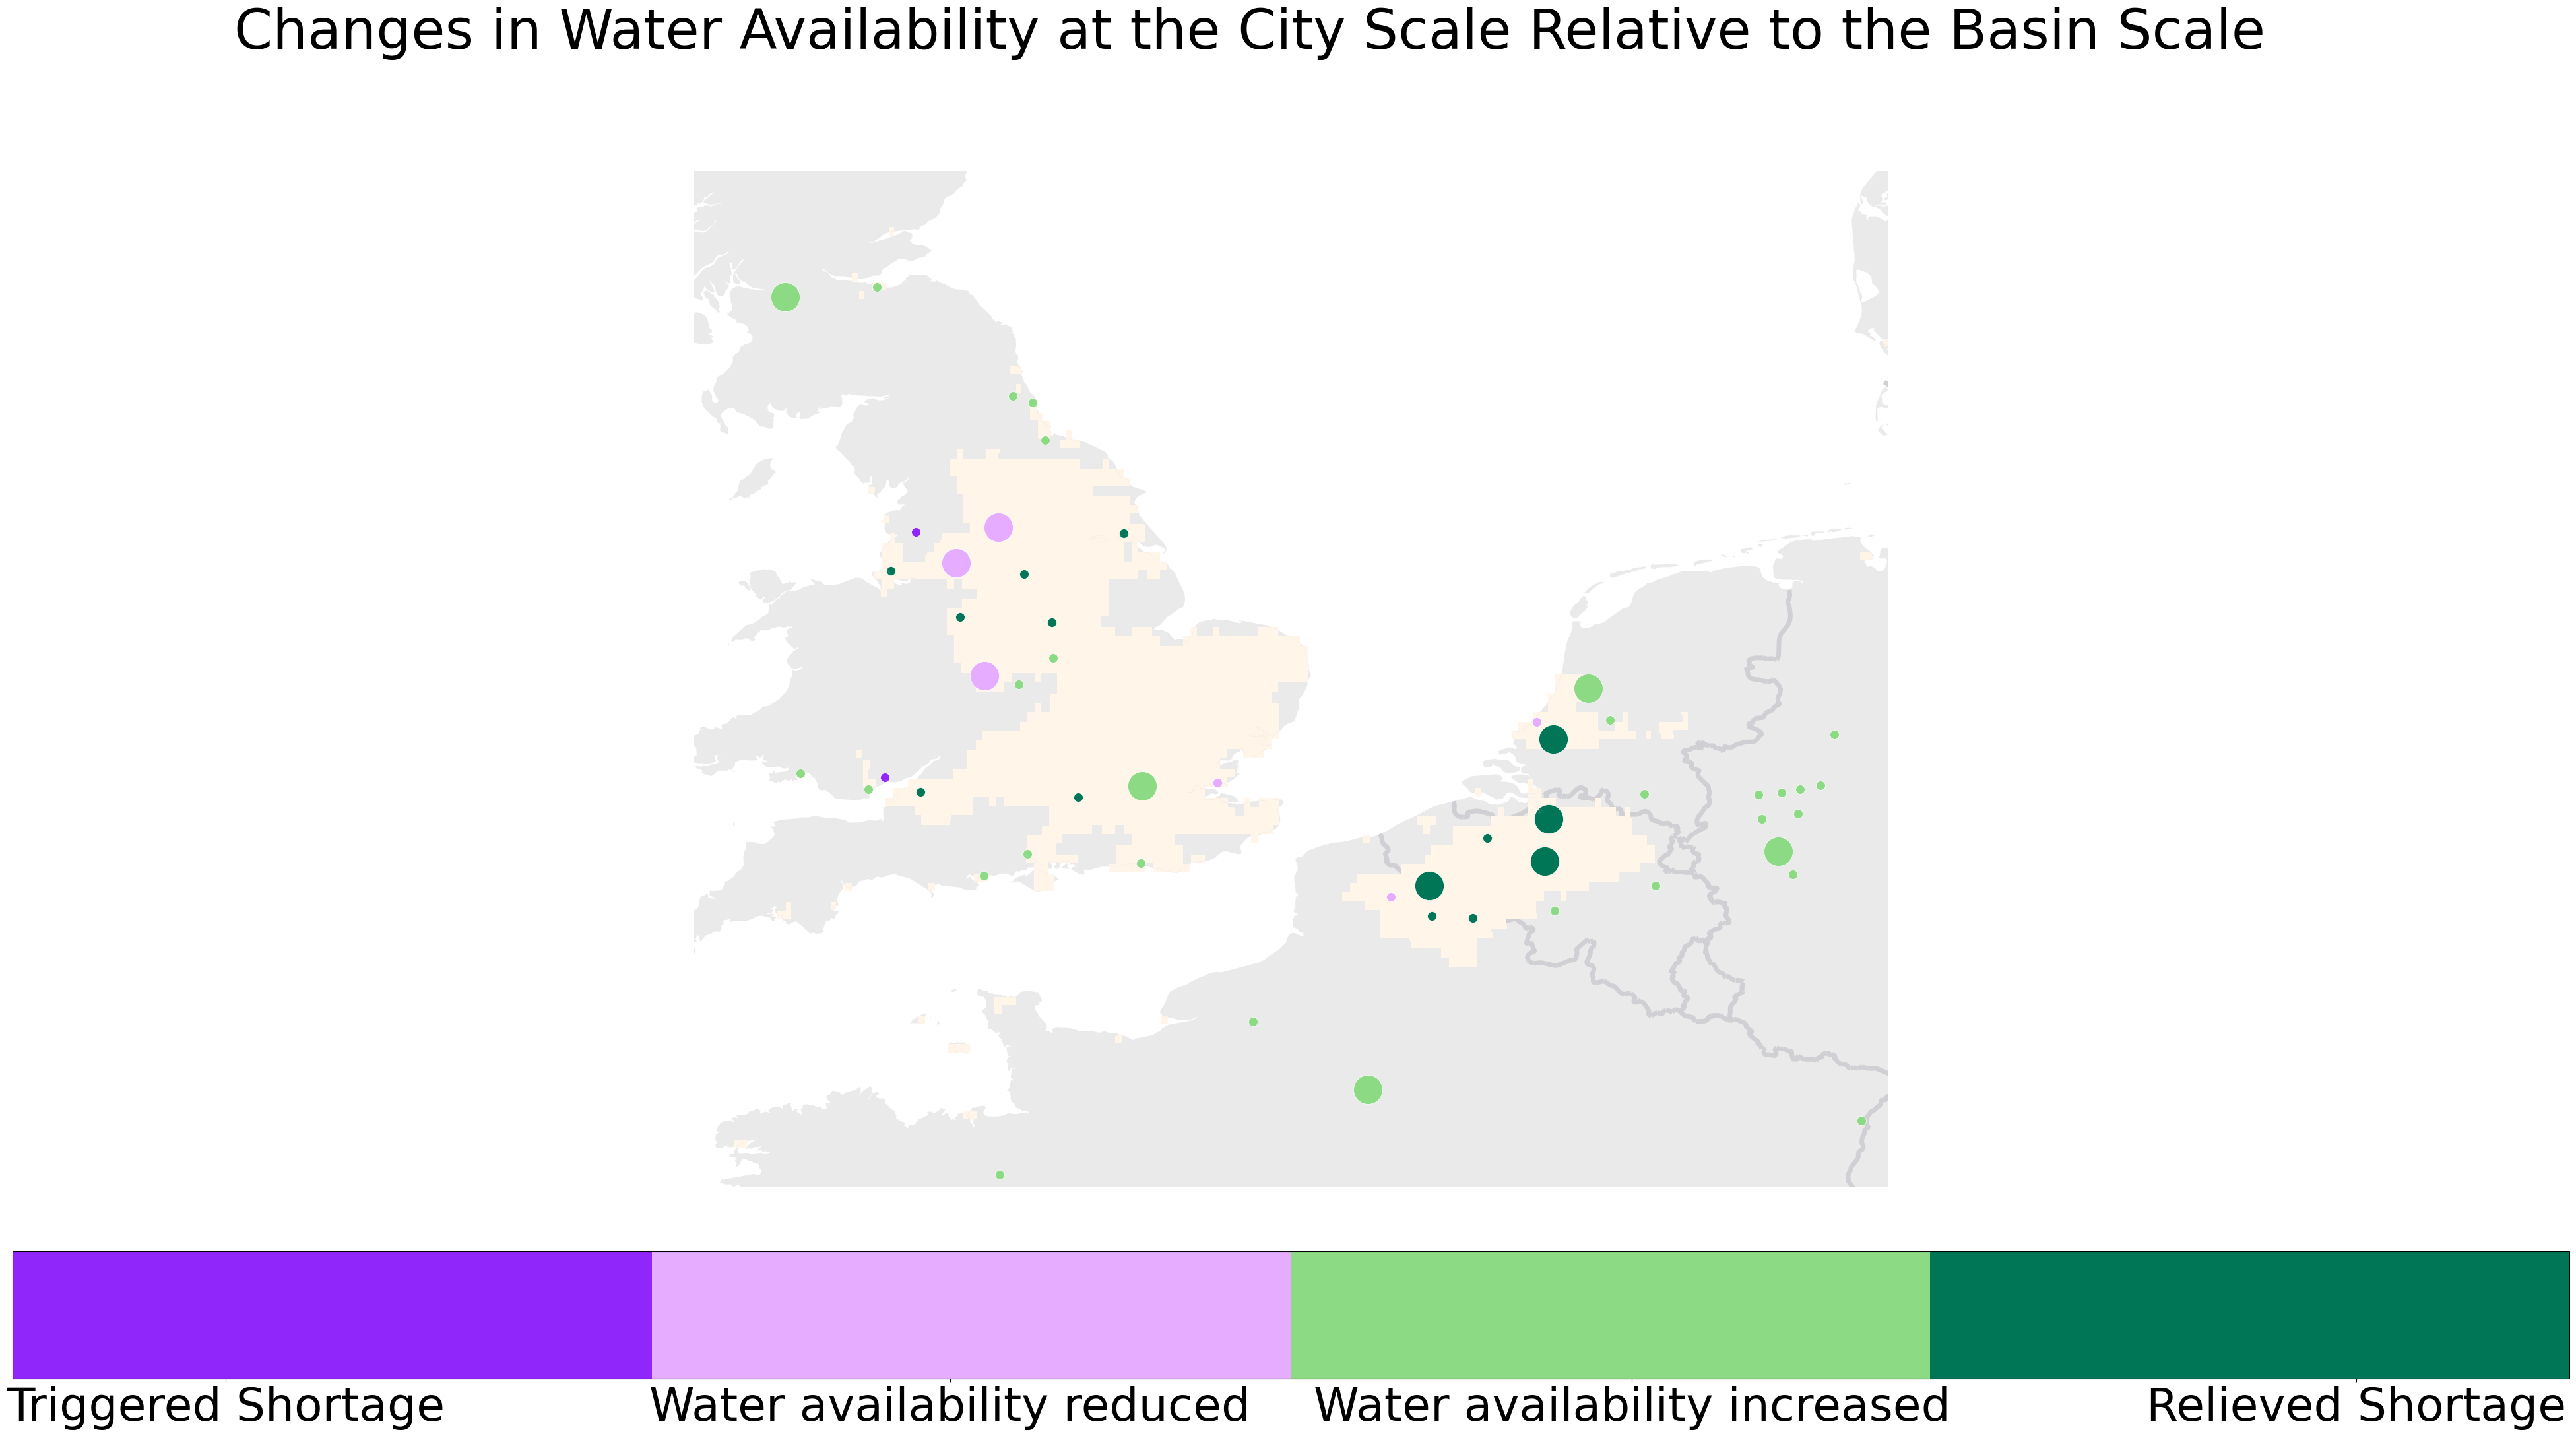

In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
city_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat_100km_abandon_revised.npy'
basin_path = f'{h08dir}/wsi/dat/cmy/cmy_basinlonlat.npy'
city_list = np.load(city_path)
basin_list = np.load(basin_path)

mpcy_path = f"{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt"
with open(mpcy_path, 'r') as files:
    text = files.readlines()

population = []
mpcy_lst = []

for ind in range(1, 1861):
    line = text[ind]
    parts = line.split('|')
    parts = [item.strip() for item in parts]
    
    city_num = int(parts[0])
    flag = parts[1]
    
    if flag == 'NoMASK':
        continue
    else:
        rate = parts[2]
        wup = float(parts[3])
        wup_unit = wup / 1e3
        dwn = float(parts[4])
        dwn_unit = dwn
        if parts[12]:
            ava_int = float(parts[12])
            ava_unit = ava_int / 1e9
        else:
            ava_int = float(parts[5])
            ava_unit = ava_int / 1e9
        if parts[13]:
            mpcy_int = float(parts[13])
        else:
            mpcy_int = float(parts[6])
            
        # check error
        if mpcy_int <= 0:
            print(ind, mpcy_int)

    mpcy_lst.append(mpcy_int)
    population.append(dwn_unit)

### j > 1000
# j > k and k > 1000
# j > k and k < 1000
# k > j
### j < 1000
# j > k and k < 1000
# k > j and k < 1000
# k > j and k > 1000

### red
# j > k and k < 1000 and j > 1000 * stress switch
# j > k and k < 1000 and j < 1000 * worse stress
# j > k and k > 1000 and j > 1000 * slight change
### blue 
# k > j and k > 1000 and j > 1000 * better stress
# k > j and k < 1000 and j < 1000 * slight change
# k > j and k > 1000 and j < 1000 * stress switch

stress_thres = 1000
FLAG = []

for i, j, k in zip(city_list, basin_list, mpcy_lst):
    l = j[3]
    # l is basin mpcy and k is city mpcy
    if l > k:
        if   k < stress_thres and l > stress_thres:
            flag = 1
        elif k < stress_thres and l < stress_thres:
            flag = 2
        elif k > stress_thres and l > stress_thres:
            flag = 2
    elif k > l:
        if   k > stress_thres and l > stress_thres:
            flag = 3
        elif k < stress_thres and l < stress_thres:
            flag = 3
        elif k > stress_thres and l < stress_thres:
            flag = 4
        
    FLAG.append([i[0], i[1], i[2], flag])

# string to float
flag_array = np.array(FLAG, dtype=object)
for i in range(len(flag_array)):
    flag_array[i] = flag_array[i].astype(float)
print(flag_array[0])

def plot_world(array, norm, cmap, extent):
    plt.rcParams["font.size"] = 50
    projection = ccrs.Robinson(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50, 25), edgecolor='none', subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=crs)

    # scatter plot
    for i, pop in zip(array, pop_array):
        if pop >= 1e7:
            size = 4000
        elif 1e6 <= pop and pop < 1e7:
            size = 1000
        else:
            size = 100
        ax.scatter(i[1], i[2], c=i[3], s=size, cmap=cmap, norm=norm,
                   transform=ccrs.PlateCarree(), alpha=1, edgecolor='white', linewidth=0.5, zorder=1)

    # background plot
    #light_cmap = mcolors.ListedColormap(['#fcf5b3'])
    #ax.imshow(light_basin, transform=ccrs.PlateCarree(), cmap=light_cmap)
    heavy_cmap = mcolors.ListedColormap(['#f3d061'])
    heavy_cmap = mcolors.ListedColormap(['#fff5e9'])
    ax.imshow(heavy_basin, transform=ccrs.PlateCarree(), cmap=heavy_cmap, zorder=0)
        
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1, edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=5, edgecolor='#d0cfd4', zorder=-1)
    ax.spines['geo'].set_visible(False)

    # colorbar plot
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks([1.25, 2.1, 2.9, 3.75])  # Ticksの設定
    cbar.set_ticklabels(['Triggered Shortage', 'Water availability reduced', 'Water availability increased', 'Relieved Shortage'])  # Tick labelsの設定
    fig.suptitle('Changes in Water Availability at the City Scale Relative to the Basin Scale')
    plt.show()

cmap_base = plt.get_cmap('PiYG')
colors = cmap_base(np.linspace(0, 1, 4))
cmap_discrete = mcolors.ListedColormap(['#9026f9', '#e6acff', '#8cdb84', '#007656'])

extent = [-5, 8, 48, 57]
norm = mcolors.TwoSlopeNorm(vcenter=2.5, vmin=1, vmax=4)
plot_world(flag_array, norm, cmap_discrete, extent)

[1.0 139.69171 35.6895 1.0]


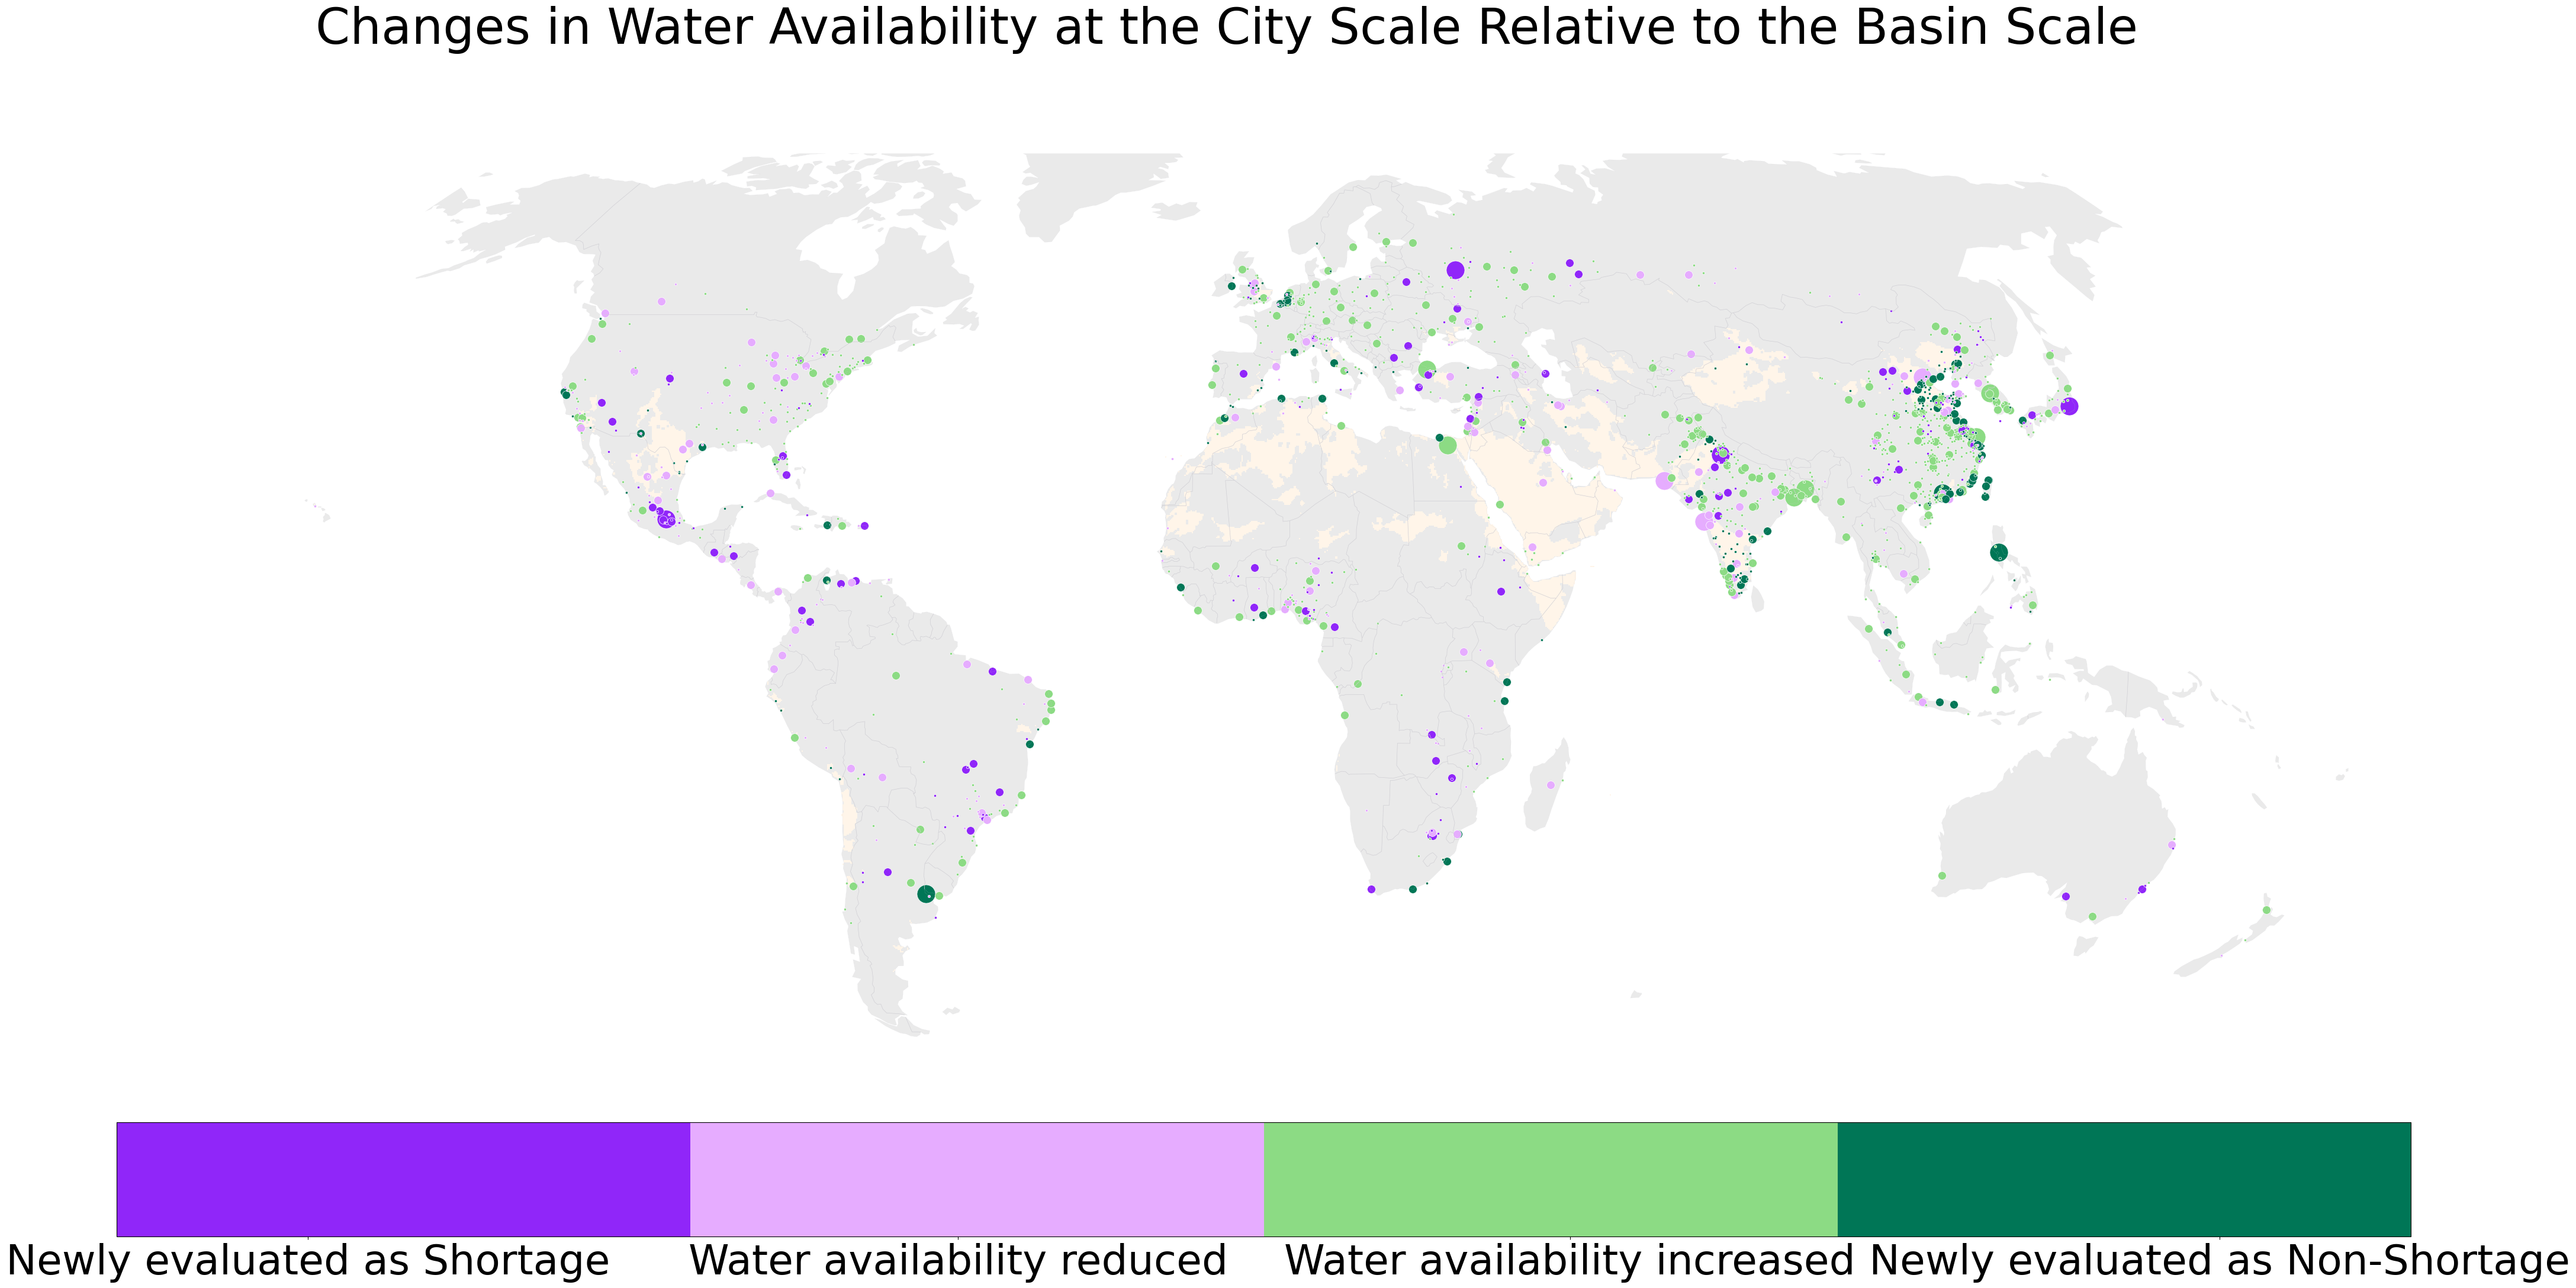

In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
city_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat_100km_abandon_revised.npy'
basin_path = f'{h08dir}/wsi/dat/cmy/cmy_basinlonlat.npy'
city_list = np.load(city_path)
basin_list = np.load(basin_path)

mpcy_path = f"{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt"
with open(mpcy_path, 'r') as files:
    text = files.readlines()

population = []
mpcy_lst = []

for ind in range(1, 1861):
    line = text[ind]
    parts = line.split('|')
    parts = [item.strip() for item in parts]
    
    city_num = int(parts[0])
    flag = parts[1]
    
    if flag == 'NoMASK':
        continue
    else:
        rate = parts[2]
        wup = float(parts[3])
        wup_unit = wup / 1e3
        dwn = float(parts[4])
        dwn_unit = dwn
        if parts[12]:
            ava_int = float(parts[12])
            ava_unit = ava_int / 1e9
        else:
            ava_int = float(parts[5])
            ava_unit = ava_int / 1e9
        if parts[13]:
            mpcy_int = float(parts[13])
        else:
            mpcy_int = float(parts[6])
            
        # check error
        if mpcy_int <= 0:
            print(ind, mpcy_int)

    mpcy_lst.append(mpcy_int)
    population.append(dwn_unit)

### j > 1000
# j > k and k > 1000
# j > k and k < 1000
# k > j
### j < 1000
# j > k and k < 1000
# k > j and k < 1000
# k > j and k > 1000

### red
# j > k and k < 1000 and j > 1000 * stress switch
# j > k and k < 1000 and j < 1000 * worse stress
# j > k and k > 1000 and j > 1000 * slight change
### blue 
# k > j and k > 1000 and j > 1000 * better stress
# k > j and k < 1000 and j < 1000 * slight change
# k > j and k > 1000 and j < 1000 * stress switch

stress_thres = 1000
FLAG = []

for i, j, k in zip(city_list, basin_list, mpcy_lst):
    l = j[3]
    # l is basin mpcy and k is city mpcy
    if l > k:
        if   k < stress_thres and l > stress_thres:
            flag = 1
        elif k < stress_thres and l < stress_thres:
            flag = 2
        elif k > stress_thres and l > stress_thres:
            flag = 2
    elif k > l:
        if   k > stress_thres and l > stress_thres:
            flag = 3
        elif k < stress_thres and l < stress_thres:
            flag = 3
        elif k > stress_thres and l < stress_thres:
            flag = 4
        
    FLAG.append([i[0], i[1], i[2], flag])

# string to float
flag_array = np.array(FLAG, dtype=object)
for i in range(len(flag_array)):
    flag_array[i] = flag_array[i].astype(float)
print(flag_array[0])

def plot_world(array, norm, cmap, extent):
    plt.rcParams["font.size"] = 50
    projection = ccrs.Robinson(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50, 25), edgecolor='none', subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=crs)

    # scatter plot
    for i, pop in zip(array, pop_array):
        if pop >= 1e7:
            size = 500
        elif 1e6 <= pop and pop < 1e7:
            size = 100
        else:
            size = 10
        ax.scatter(i[1], i[2], c=i[3], s=size, cmap=cmap, norm=norm,
                   transform=ccrs.PlateCarree(), alpha=1, edgecolor='white', linewidth=0.5)

    # background plot
    #light_cmap = mcolors.ListedColormap(['#fcf5b3'])
    #ax.imshow(light_basin, transform=ccrs.PlateCarree(), cmap=light_cmap)
    heavy_cmap = mcolors.ListedColormap(['#f3d061'])
    heavy_cmap = mcolors.ListedColormap(['#fff5e9'])
    ax.imshow(heavy_basin, transform=ccrs.PlateCarree(), cmap=heavy_cmap)
        
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1, edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='#d0cfd4')
    ax.spines['geo'].set_visible(False)

    # colorbar plot
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks([1.25, 2.1, 2.9, 3.75])  # Ticksの設定
    cbar.set_ticklabels(['Newly evaluated as Shortage', 'Water availability reduced', 'Water availability increased', 'Newly evaluated as Non-Shortage'])  # Tick labelsの設定
    fig.suptitle('Changes in Water Availability at the City Scale Relative to the Basin Scale')
    plt.show()

cmap_base = plt.get_cmap('PiYG')
colors = cmap_base(np.linspace(0, 1, 4))
cmap_discrete = mcolors.ListedColormap(['#9026f9', '#e6acff', '#8cdb84', '#007656'])

extent = [-180, 180, -60, 75]
norm = mcolors.TwoSlopeNorm(vcenter=2.5, vmin=1, vmax=4)
plot_world(flag_array, norm, cmap_discrete, extent)